In [6]:
from dotenv import load_dotenv
load_dotenv()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
from datetime import datetime
import time
from typing import Dict, List, Any, Optional, Tuple
import json
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.api import ARIMA
from arch import arch_model
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import shap
import warnings
import zipfile
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

# Configure settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# FRED availability (optional)
try:
    from fredapi import Fred
    _HAS_FREDAPI = True
except Exception:
    _HAS_FREDAPI = False

FRED_API_KEY = os.getenv("FRED_API_KEY")
if not FRED_API_KEY:
    raise RuntimeError(
        "FRED_API_KEY not found"
    )

if _HAS_FREDAPI:
    fred = Fred(api_key=FRED_API_KEY)
    
EIA_API_KEY = os.getenv("EIA_API_KEY")
if not EIA_API_KEY:
    raise RuntimeError(
        "EIA_API_KEY not found in environment."
    )

# optional holiday calendar for release-day shifts
try:
    import holidays
    US_HOLIDAYS = holidays.UnitedStates()
except Exception:
    US_HOLIDAYS = None


## Helper functions — Market ingestion, geopolitics, GPR/EPU/BDI, weather, analysis helpers

In [7]:
def ingest_data_tickers():
    """
    Ingests raw time series data. Downloads daily data from Yahoo Finance.

    Includes:
    - WTI (CL=F), Brent (BZ=F), Gold (GC=F), Copper (HG=F)
    - DXY (DX-Y.NYB), 10Y Treasury (^TNX), VIX (^VIX)
    - S&P 500 (^GSPC) and realized volatility (20D rolling, annualized)
    - 3M Treasury Bill (^IRX) as short-term rate proxy
    - NASDAQ (^IXIC)
    """

    # Define tickers and column mapping
    # WTI is a lighter and sweeter crude oil, while Brent is heavier and more sour.
    # Brent is more expensive than WTI due to its higher sulfur content and transportation costs.
    # WTI is more liquid and has a higher demand for refined products, such as gasoline and diesel.
    # Brent is more stable and has a lower volatility compared to WTI.
    # WTI is more sensitive to supply disruptions, while Brent is more resilient to geopolitical tensions.
    # WTI is more sensitive to seasonal demand patterns, while Brent is less affected by these variations.


    # Our quant model will predict wti price, and we will use the spread between wti and brent as a proxy for the oil price.
    
    tickers = {
        'CL=F': 'wti_price',          # WTI Crude Oil Futures
        'BZ=F': 'brent_price',        # Brent Crude Oil Futures
        'GC=F': 'gold_price',         # Gold Futures
        'HG=F': 'copper_price',       # Copper Futures
        'DX-Y.NYB': 'dxy',            # US Dollar Index
        '^TNX': '10y_yield',          # 10-Year Treasury Yield (percent)
        '^VIX': 'vix',                # CBOE Volatility Index
        '^GSPC': 'sp500',             # S&P 500 Index
        '^IRX': 't3m_yield',          # 13-Week T-Bill Yield (percent)
        '^IXIC': 'nasdaq',            # NASDAQ Composite Index (optional)
    }

    end = datetime.now().strftime('%Y-%m-%d')

    # Download adjusted close prices for all tickers
    data = yf.download(list(tickers.keys()), start='2007-07-30', end=end, progress=False) # Maybe we can change starting date, I remember picking this because one of the data sources started from then!
    
    data = data['Close'] # taking the adjusted close prices
    data = data.rename(columns=tickers)

    # Compute S&P 500 realized volatility (20-day rolling sum of squared log returns, annualized)
    if 'sp500' in data.columns:
        sp500_logret = np.log(data['sp500'] / data['sp500'].shift(1))
        sp500_sqret = sp500_logret ** 2 # Squared log returns (Volatility)
        # data['sp500_volatility'] = np.sqrt(sp500_sqret.rolling(window=20, min_periods=1).sum() * 252) # Annualized volatility, UPDATE: I think this is wrong, i think the solution is to mean it, and not sum!
        data['sp500_volatility'] = np.sqrt(sp500_sqret.rolling(window=20, min_periods=1).mean() * 252) # I think corrected version!

    # Handle missing values (forward-fill across non-trading days), the first few rows will be NaN
    data = data.ffill().dropna()    

    df = data.copy()

    metadata = {
        'wti_price': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'brent_price': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'gold_price': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'copper_price': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'dxy': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        '10y_yield': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        't3m_yield': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'vix': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'sp500': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
        'sp500_volatility': {'frequency': 'daily', 'source': 'Computed from ^GSPC', 'publication_lag': '0D'},
        'nasdaq': {'frequency': 'daily', 'source': 'Yahoo Finance', 'publication_lag': '0D'},
    }

    print("Data ingestion complete.")
    return df, metadata




# --- Conflict & UCDP helpers ---
# I chose these countries because they are all major oil producers, and they are all important to the global oil market.
KEY_ACTORS = {
    'United States of America', 'Yemen (North Yemen)', 'United Arab Emirates', 'Saudi Arabia', 'Russia',
    'Iran', 'Iraq', 'Egypt', 'Oman', 'Kuwait'
}


# Politcal parties in the key countries
sides = [
    "Government of Iran", "Government of Iraq", "Government of Russia (Soviet Union)",
    "Government of Kuwait", "Libya Dawn", "LNA", "Forces of Khalifa al-Ghawil",
    "February 17 Martyrs Brigade", "Rafallah al-Sahati Brigade", "Qadhadhfa",
    "Mashashia", "Awlad Suleiman", "Awlad Zeid", "Ajdabiya Revolutionaries Shura Council",
    "Government of Yemen (North Yemen)", "Forces of the Presidential Leadership Council",
    "Democratic Republic of Yemen", "Islah", "Hezbollah", "Government of Syria",
    "Government of United States of America"
]

# Lower case for the key actors and sides
KEY_ACTORS_LOWER = {x.strip().lower() for x in KEY_ACTORS}
SIDES_SET_LOWER = {x.strip().lower() for x in sides}

def _find_column(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns: return c
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map: return lower_map[c.lower()]
    return None

def _normalize_text(series: pd.Series) -> pd.Series:
    if series is None: return pd.Series([], dtype='object')
    return series.fillna('').astype(str).str.strip().str.lower()

def _series_in_set(series: pd.Series, values_lower: set) -> pd.Series:
    s = _normalize_text(series)
    return s.isin(values_lower)

def _read_zip_select(zip_path: str, prefer_contains=None) -> pd.DataFrame:
    with zipfile.ZipFile(zip_path) as z:
        csv_names = [n for n in z.namelist() if n.lower().endswith('.csv')]
        if not csv_names: raise ValueError(f"No CSV files found in {zip_path}")
        target = csv_names[0]
        if prefer_contains:
            for pat in prefer_contains:
                matches = [n for n in csv_names if pat.lower() in n.lower()]
                if matches:
                    target = matches[0]
                    break
        with z.open(target) as f:
            df = pd.read_csv(f, low_memory=False)
    
    # Renaming the columns, just for clarity and simplicity
    rename_map = {
        _find_column(df, ['Year', 'year']): 'Year',
        _find_column(df, ['Country', 'country']): 'Country',
        _find_column(df, ['side_a', 'SideA', 'Side A']): 'side_a',
        _find_column(df, ['side_b', 'SideB', 'Side B']): 'side_b',
        _find_column(df, ['best', 'bd_best', 'Best', 'BEST']): 'deaths',
    }
    rename_map = {k: v for k, v in rename_map.items() if k is not None}
    df = df[list(rename_map.keys())].rename(columns=rename_map)

    if 'Year' in df.columns: df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    if 'deaths' in df.columns: df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')
    for col in ['Country', 'side_a', 'side_b']:
        if col in df.columns: df[col] = df[col].astype(str).str.strip()
    return df

def load_conflict_sources(ucdp_zip_path: str = 'datasets/ucdp-brd-conf-251-csv.zip', ged_zip_path: str = 'datasets/ged251-csv.zip'):
    brd = _read_zip_select(ucdp_zip_path, prefer_contains=['BattleDeaths', 'conf'])
    if not brd.empty:
        country_match = _series_in_set(brd.get('Country'), KEY_ACTORS_LOWER)
        sa_match = _series_in_set(brd.get('side_a'), SIDES_SET_LOWER)
        sb_match = _series_in_set(brd.get('side_b'), SIDES_SET_LOWER)
        brd['country_flag'] = country_match.astype('Int64')
        brd['side_a_flag'] = sa_match.astype('Int64')
        brd['side_b_flag'] = sb_match.astype('Int64')
        brd['flag'] = brd[['country_flag', 'side_a_flag', 'side_b_flag']].max(axis=1).astype('Int64')
        brd = brd.drop(columns=['country_flag', 'side_a_flag', 'side_b_flag'], errors='ignore')

    ged = _read_zip_select(ged_zip_path, prefer_contains=['ged', 'GED'])
    if not ged.empty:
        country_match = _series_in_set(ged.get('Country'), KEY_ACTORS_LOWER)
        sa_match = _series_in_set(ged.get('side_a'), SIDES_SET_LOWER)
        sb_match = _series_in_set(ged.get('side_b'), SIDES_SET_LOWER)
        ged['country_flag'] = country_match.astype('Int64')
        ged['side_a_flag'] = sa_match.astype('Int64')
        ged['side_b_flag'] = sb_match.astype('Int64')
        ged['flag'] = ged[['country_flag', 'side_a_flag', 'side_b_flag']].max(axis=1).astype('Int64')
        ged = ged.drop(columns=['country_flag', 'side_a_flag', 'side_b_flag'], errors='ignore')

    merged_raw = pd.concat([brd, ged], ignore_index=True, sort=False)

    def _agg_yearly(df, src):
        if df.empty: return pd.DataFrame(columns=['Year'])
        g = df.groupby('Year', dropna=True).agg(
            deaths=('deaths', 'sum'),
            flag=('flag', 'max')
        ).reset_index()
        return g.rename(columns=lambda c: f'{src}_{c}' if c != 'Year' else c)

    brd_yearly = _agg_yearly(brd, 'brd')
    ged_yearly = _agg_yearly(ged, 'ged')

    merged_yearly = pd.merge(brd_yearly, ged_yearly, on='Year', how='outer').sort_values('Year').fillna(0)
    merged_yearly['Year'] = merged_yearly['Year'].astype('Int64')
    
    return merged_raw, merged_yearly

def _prepare_annual_features(merged_yearly: pd.DataFrame) -> pd.DataFrame:
    if merged_yearly is None or merged_yearly.empty:
        return pd.DataFrame()
    
    df = merged_yearly.copy().set_index('Year')
    for col in ['brd_deaths', 'ged_deaths']:
        if col not in df.columns: df[col] = 0

    df['total_best'] = df[['brd_deaths', 'ged_deaths']].sum(axis=1)

    # Single unified flag across sources
    if 'brd_flag' not in df.columns: df['brd_flag'] = 0
    if 'ged_flag' not in df.columns: df['ged_flag'] = 0
    df['flag'] = df[['brd_flag', 'ged_flag']].max(axis=1).astype('Int64')

    df['yoy_diff_total_best'] = df['total_best'].diff()
    df['yoy_pct_total_best'] = df['total_best'].pct_change().replace([np.inf, -np.inf], 0)
    df['rolling_mean_3y_total_best'] = df['total_best'].rolling(window=3, min_periods=1).mean()
    df['rolling_std_3y_total_best'] = df['total_best'].rolling(window=3, min_periods=1).std()
    df['lag1_total_best'] = df['total_best'].shift(1)
    df['lag2_total_best'] = df['total_best'].shift(2)

    keep_cols = [
        'flag',
        'total_best', 'yoy_diff_total_best', 'yoy_pct_total_best',
        'rolling_mean_3y_total_best', 'rolling_std_3y_total_best',
        'lag1_total_best', 'lag2_total_best'
    ]
    return df[keep_cols].fillna(0)

def _annual_to_published_daily(annual_df: pd.DataFrame, df_daily_index: pd.DatetimeIndex, publication_lag_months: int = 12) -> pd.DataFrame:
    if annual_df is None or annual_df.empty:
        return pd.DataFrame(index=df_daily_index)

    availability_dates = pd.to_datetime(annual_df.index.astype(str)) + pd.DateOffset(years=1) + pd.DateOffset(months=publication_lag_months-12)
    pub_df = annual_df.copy()
    pub_df.index = availability_dates

    full_index = df_daily_index.union(pub_df.index).sort_values()
    daily_pub = pub_df.reindex(full_index).ffill().reindex(df_daily_index)
    return daily_pub

def merge_conflict_features_with_daily(df_daily: pd.DataFrame, merged_yearly: pd.DataFrame, publication_lag_months: int = 12, metadata: Optional[Dict] = None) -> Tuple[pd.DataFrame, Dict]:
    if metadata is None: metadata = {}
    if df_daily is None or df_daily.empty: raise ValueError("df_daily must be a non-empty DataFrame")
    if not isinstance(df_daily.index, pd.DatetimeIndex): raise ValueError("df_daily.index must be a pandas.DatetimeIndex")

    annual_feats = _prepare_annual_features(merged_yearly)
    if annual_feats.empty:
        return df_daily.copy(), metadata

    daily_feature_df = _annual_to_published_daily(annual_feats, df_daily.index, publication_lag_months=publication_lag_months)
    out = df_daily.merge(daily_feature_df, how='left', left_index=True, right_index=True)

    new_meta = {c: {'frequency': 'annual->daily (published, ffilled)', 'source': 'UCDP', 'publication_lag_months': publication_lag_months} for c in daily_feature_df.columns}
    combined_meta = {**metadata, **new_meta}
    return out, combined_meta

def add_gpr_features(df_daily: pd.DataFrame, gpr_daily_path: str, gpr_monthly_path: str, country_list=None) -> pd.DataFrame:
    df = df_daily.copy()

    # --- Load daily GPR data ---
    gpr_daily = pd.read_excel(gpr_daily_path).rename(columns={'yyyymmdd': 'date'})
    gpr_daily['date'] = pd.to_datetime(gpr_daily['date'], format='%Y%m%d')
    gpr_daily = gpr_daily.set_index('date').sort_index()
    daily_features = ['GPRD', 'GPRD_ACT', 'GPRD_THREAT', 'GPRD_MA7', 'GPRD_MA30']
    df = df.merge(gpr_daily[daily_features], how='left', left_index=True, right_index=True)

    # --- Load monthly GPR data ---
    gpr_monthly = pd.read_excel(gpr_monthly_path)
    gpr_monthly['month'] = pd.to_datetime(gpr_monthly['month'])
    gpr_monthly = gpr_monthly.set_index('month').sort_index()
    monthly_features = ['GPR', 'GPRT', 'GPRA']
    if country_list:
        for c in country_list:
            col_name = f'GPRC_{c.upper()[:3]}'
            if col_name in gpr_monthly.columns:
                monthly_features.append(col_name)
    
    # Forward-fill monthly data to daily frequency
    gpr_monthly_daily = gpr_monthly[monthly_features].reindex(df.index, method='ffill')
    df = df.merge(gpr_monthly_daily, how='left', left_index=True, right_index=True)
    
    return df

def add_daily_epu(df_daily: pd.DataFrame, epu_path: str, lag: int = 1) -> pd.DataFrame:
    df = df_daily.copy()
    epu = pd.read_csv(epu_path)
    epu['date'] = pd.to_datetime(epu[['year', 'month', 'day']])
    epu = epu.rename(columns={'daily_policy_index': 'EPU_index'})
    epu = epu[['date', 'EPU_index']].set_index('date').sort_index()

    if lag > 0:
        epu['EPU_index'] = epu['EPU_index'].shift(lag)

    df = df.merge(epu, how='left', left_index=True, right_index=True)
    return df

def add_bdi_prices(df_daily: pd.DataFrame, bdi_path: str, lag: int = 1, date_column: Optional[str] = None) -> pd.DataFrame:
    df = df_daily.copy()
    if bdi_path.lower().endswith('.csv'):
        bdi = pd.read_csv(bdi_path)
    else:
        bdi = pd.read_excel(bdi_path)

    def _find_date_col(frame):
        candidates = ['Date', 'date', 'As of Date', 'timestamp']
        for c in candidates:
            if c in frame.columns: return c
        raise ValueError("No date column found in BDI file.")
    
    date_col = date_column or _find_date_col(bdi)
    bdi['date'] = pd.to_datetime(bdi[date_col])
    bdi = bdi.set_index('date').sort_index()

    rename_map = {c: f"BDIY {c.split()[-1]}" for c in bdi.columns if isinstance(c, str)}
    bdi = bdi.rename(columns=rename_map)

    # Reindex to match the main df's date range and ffill
    bdi_daily = bdi.reindex(df.index).ffill()

    if lag > 0:
        bdi_daily = bdi_daily.shift(lag)

    return df.merge(bdi_daily, how='left', left_index=True, right_index=True)

# --- Weather helpers ---
city_coords = {
    'Houston': (29.7604, -95.3698), 'Dallas': (32.7767, -96.7970),
    'Denver': (39.7392, -104.9903), 'New York': (40.7128, -74.0060),
    'Los Angeles': (34.0522, -118.2437), 'Riyadh': (24.7136, 46.6753),
    'London': (51.5074, -0.1278)
}

def fetch_weather_data(city_name, lat, lon, start_date, end_date, timezone="UTC"):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {"latitude": lat, "longitude": lon, "start_date": start_date, "end_date": end_date, "daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max"], "timezone": timezone}
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    if "daily" not in data: return pd.DataFrame()
    df = pd.DataFrame(data["daily"])
    df["city"] = city_name
    return df

def fetch_city_weather_batched(city_name, lat, lon, start_date, end_date, chunk_days=365, sleep_sec=0.2):
    frames = []
    current_start = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    while current_start <= end_dt:
        current_end = current_start + pd.Timedelta(days=chunk_days - 1)
        if current_end > end_dt:
            current_end = end_dt
        df_part = fetch_weather_data(city_name, lat, lon, current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'))
        if not df_part.empty:
            frames.append(df_part)
        time.sleep(sleep_sec)
        current_start += pd.Timedelta(days=chunk_days)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

def get_weather_data_for_analysis(start_date, end_date, cities=None):
    target_cities = cities or list(city_coords.keys())
    frames = [fetch_city_weather_batched(c, *city_coords[c], start_date, end_date) for c in target_cities]
    if not any(not df.empty for df in frames): return pd.DataFrame()
    
    out = pd.concat(frames, ignore_index=True).rename(columns={'time': 'date', 'temperature_2m_mean': 'temp_mean_c', 'precipitation_sum': 'precip_mm', 'wind_speed_10m_max': 'wind_max_ms'})
    out['date'] = pd.to_datetime(out['date'])
    return out

def integrate_weather_with_oil_data(oil_data: pd.DataFrame, weather_data: pd.DataFrame) -> pd.DataFrame:
    if weather_data.empty:
        print("No weather data to integrate")
        return oil_data
    
    weather_daily = weather_data.groupby('date').agg(
        temp_mean_c_mean=('temp_mean_c', 'mean'), temp_mean_c_std=('temp_mean_c', 'std'),
        temp_mean_c_min=('temp_mean_c', 'min'), temp_mean_c_max=('temp_mean_c', 'max'),
        precip_mm_sum=('precip_mm', 'sum'), precip_mm_max=('precip_mm', 'max'),
        wind_max_ms_mean=('wind_max_ms', 'mean'), wind_max_ms_max=('wind_max_ms', 'max')
    )
    return oil_data.merge(weather_daily, left_index=True, right_index=True, how='left')




# We need to check this

# --- Analysis helpers ---
def plot_stationarity_check(series, series_name=''):
    """
    Plots a series, its rolling stats, and runs the ADF test.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(series, label='Original Series', color='blue', alpha=0.8)

    # Rolling statistics (using 1-year window)
    rolling_mean = series.rolling(window=252).mean()
    rolling_std = series.rolling(window=252).std()
    ax.plot(rolling_mean, color='red', label='Rolling Mean (252-day)')
    ax.plot(rolling_std, color='black', label='Rolling Std Dev (252-day)')

    # ADF Test
    result = adfuller(series.dropna())
    p_value = result[1]

    ax.legend()
    ax.set_title(
        f'Stationarity Check for {series_name}\nADF p-value: {p_value:.4f}',
        fontsize=16,
    )
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_cross_correlation(df, target_col, feature_col, max_lag=20,
                           window_size=252):
    """
    Plots the cross-correlation between a target and a feature for various
    lags. Calculates significance using a simple heuristic (2/sqrt(N)).
    """
    lags = np.arange(-max_lag, max_lag + 1)

    # Ensure no NaNs for correlation calculation within the rolling window
    temp_df = df[[target_col, feature_col]].dropna()
    if temp_df.empty:
        print(
            f"Skipping cross-correlation for {target_col} and {feature_col} "
            "due to empty data after dropna."
        )
        return

    corrs = [
        temp_df[target_col].corr(temp_df[feature_col].shift(lag)) for lag in lags
    ]

    # Calculate confidence interval (approx. 95%)
    # For N samples, standard error is 1/sqrt(N-1). Approx 2*SE for 95% CI.
    # N is the number of effective observations after dropping NaNs and
    # shifting.
    N = len(temp_df) - max_lag  # Conservative estimate
    if N > 1:
        confidence_bound = 2 / np.sqrt(N)
    else:
        confidence_bound = 0  # No confidence if too few samples

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.stem(lags, corrs, basefmt="C7--")

    ax.axhline(confidence_bound, color='red', linestyle='--', lw=1,
               label=f'95% CI (approx)')
    ax.axhline(-confidence_bound, color='red', linestyle='--', lw=1)
    ax.axvline(0, color='black', linestyle=':', lw=1)  # Lag 0 line

    ax.set_title(
        f'Cross-Correlation: {target_col} vs. Lagged {feature_col}',
        fontsize=16,
    )
    ax.set_xlabel(
        f'Lag (days, positive means {feature_col} lags {target_col})',
        fontsize=12,
    )
    ax.set_ylabel('Correlation Coefficient', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()


In [8]:
# --- Data fetching & initial ingestion ---
raw_data, metadata = ingest_data_tickers()
print("Raw Data Head:")
print(raw_data.head())

Data ingestion complete.
Raw Data Head:
Ticker      brent_price  wti_price        dxy  gold_price  copper_price  \
Date                                                                      
2007-07-31    77.050003  78.209999  80.769997  666.900024        3.6535   
2007-08-01    75.349998  76.529999  80.870003  663.599976        3.5950   
2007-08-02    75.760002  76.860001  80.709999  664.599976        3.5750   
2007-08-03    74.750000  75.480003  80.180000  672.500000        3.4845   
2007-08-06    71.169998  72.059998  80.250000  671.500000        3.4785   

Ticker            sp500  t3m_yield       nasdaq  10y_yield        vix  \
Date                                                                    
2007-07-31  1455.270020      4.810  2546.270020      4.771  23.520000   
2007-08-01  1465.810059      4.740  2553.870117      4.759  23.670000   
2007-08-02  1472.199951      4.745  2575.979980      4.753  21.219999   
2007-08-03  1433.060059      4.700  2511.250000      4.700  25.160000


--- Visualizing Initial Raw Market Data ---


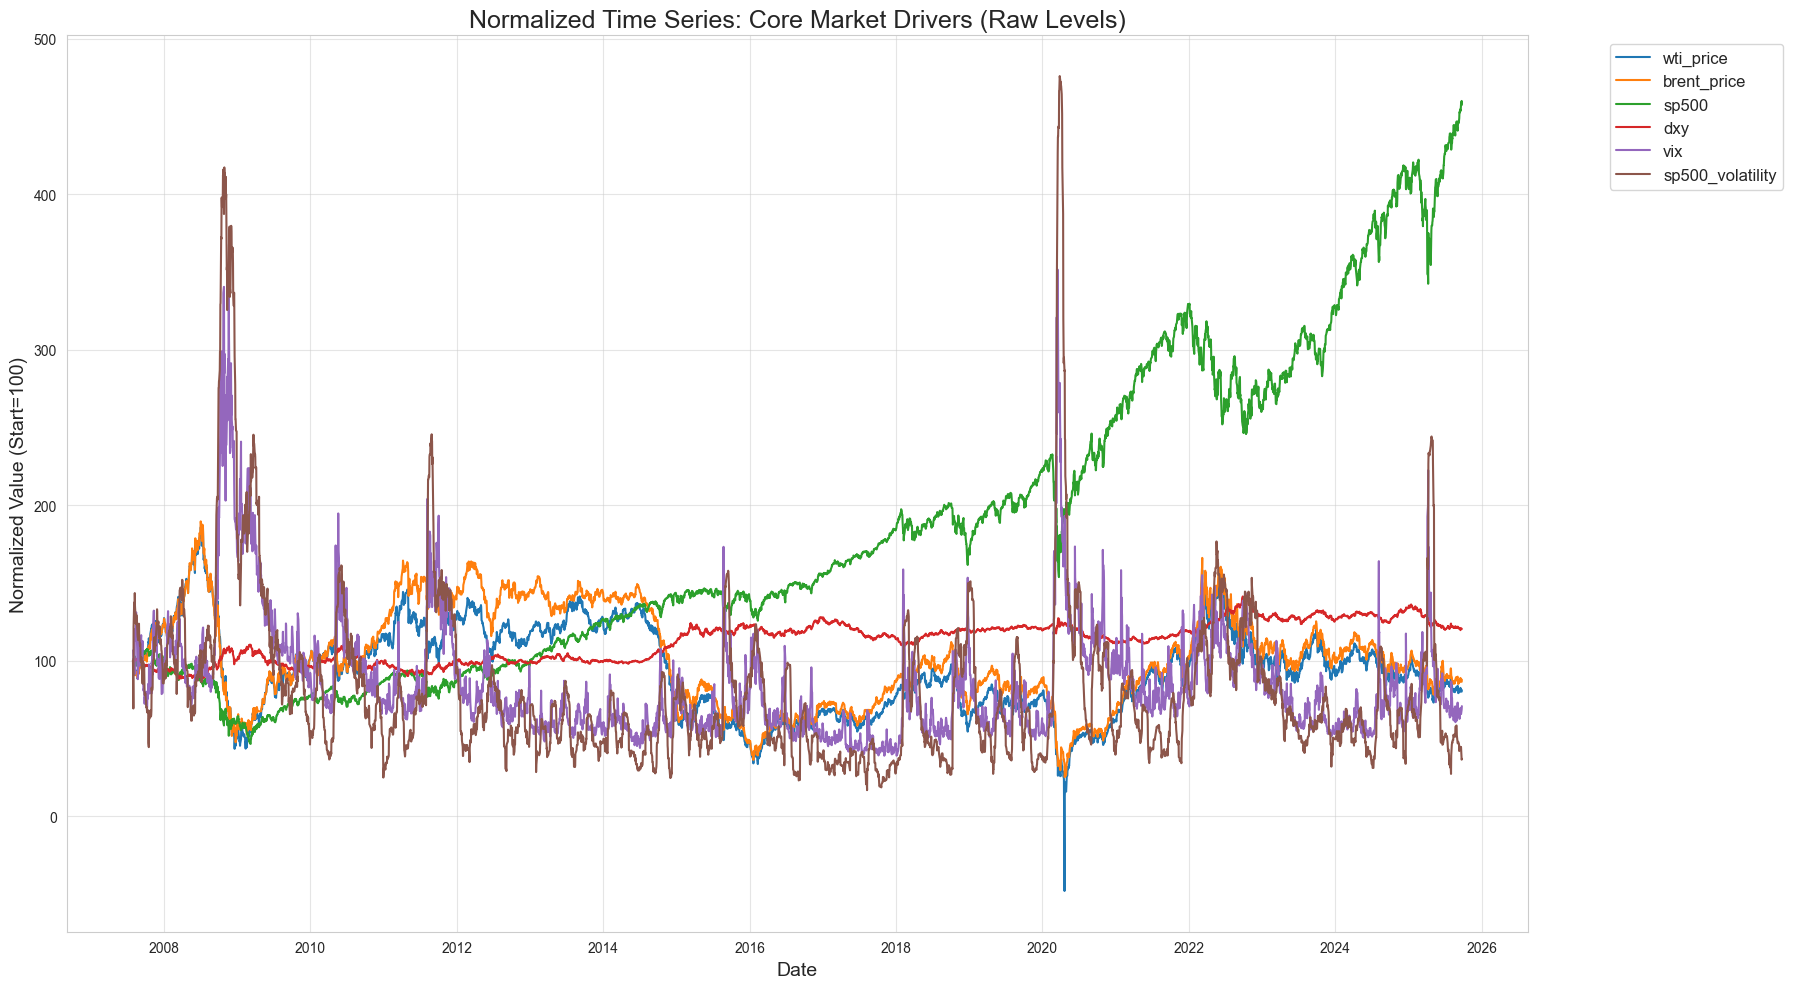

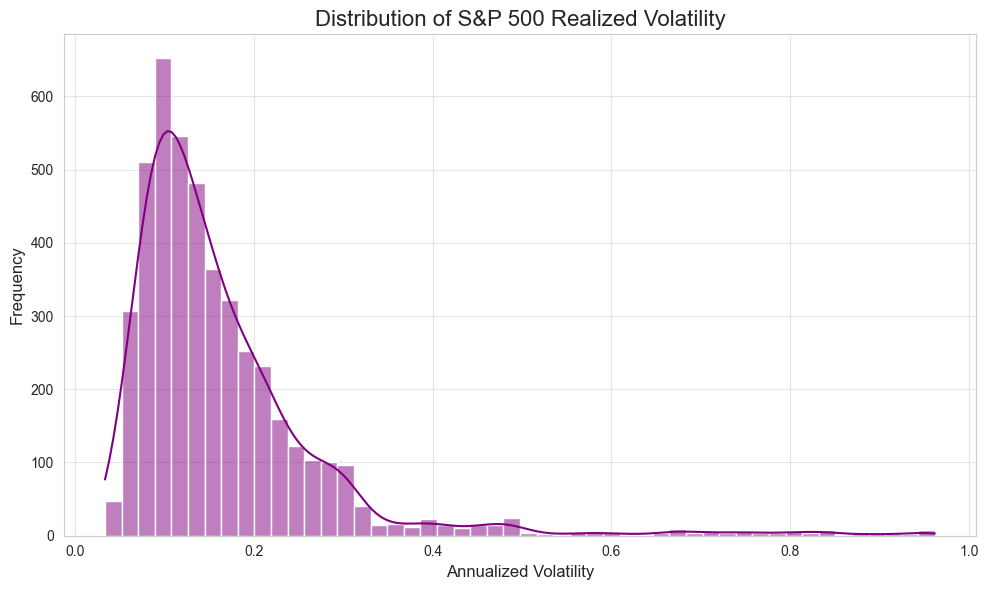

In [9]:
# --- Initial visualization of core market drivers (raw levels, normalized) ---
print("\n--- Visualizing Initial Raw Market Data ---")
# Select key series for initial overview (raw levels)
key_series_initial = ['wti_price', 'brent_price', 'sp500', 'dxy', 'vix', 'sp500_volatility']
df_plot_initial = raw_data[key_series_initial].dropna()

# Normalize to 100 at start for comparability
df_plot_initial_normalized = (df_plot_initial / df_plot_initial.iloc[0]) * 100

plt.figure(figsize=(18, 10))
for col in df_plot_initial_normalized.columns:
    plt.plot(df_plot_initial_normalized.index, df_plot_initial_normalized[col], label=col, linewidth=1.5)

plt.title('Normalized Time Series: Core Market Drivers (Raw Levels)', fontsize=18)
plt.ylabel('Normalized Value (Start=100)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- Distribution of S&P 500 Realized Volatility ---
plt.figure(figsize=(10, 6))
sns.histplot(raw_data['sp500_volatility'].dropna(), kde=True, bins=50, color='purple')
plt.title('Distribution of S&P 500 Realized Volatility', fontsize=16)
plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:
# --- Conflict data ingestion and merging with daily data ---
merged_raw, merged_yearly = load_conflict_sources('datasets/ucdp-brd-conf-251-csv.zip', 'datasets/ged251-csv.zip')
raw_data_aug, metadata = merge_conflict_features_with_daily(raw_data, merged_yearly, publication_lag_months=12, metadata=metadata)
print("\nDataFrame after adding conflict features (with single 'flag' column):")
print(raw_data_aug.head())


DataFrame after adding conflict features (with single 'flag' column):
            brent_price  wti_price        dxy  gold_price  copper_price  \
Date                                                                      
2007-07-31    77.050003  78.209999  80.769997  666.900024        3.6535   
2007-08-01    75.349998  76.529999  80.870003  663.599976        3.5950   
2007-08-02    75.760002  76.860001  80.709999  664.599976        3.5750   
2007-08-03    74.750000  75.480003  80.180000  672.500000        3.4845   
2007-08-06    71.169998  72.059998  80.250000  671.500000        3.4785   

                  sp500  t3m_yield       nasdaq  10y_yield        vix  \
Date                                                                    
2007-07-31  1455.270020      4.810  2546.270020      4.771  23.520000   
2007-08-01  1465.810059      4.740  2553.870117      4.759  23.670000   
2007-08-02  1472.199951      4.745  2575.979980      4.753  21.219999   
2007-08-03  1433.060059      4.700  25


--- Visualizing Conflict Features with Unified 'flag' ---


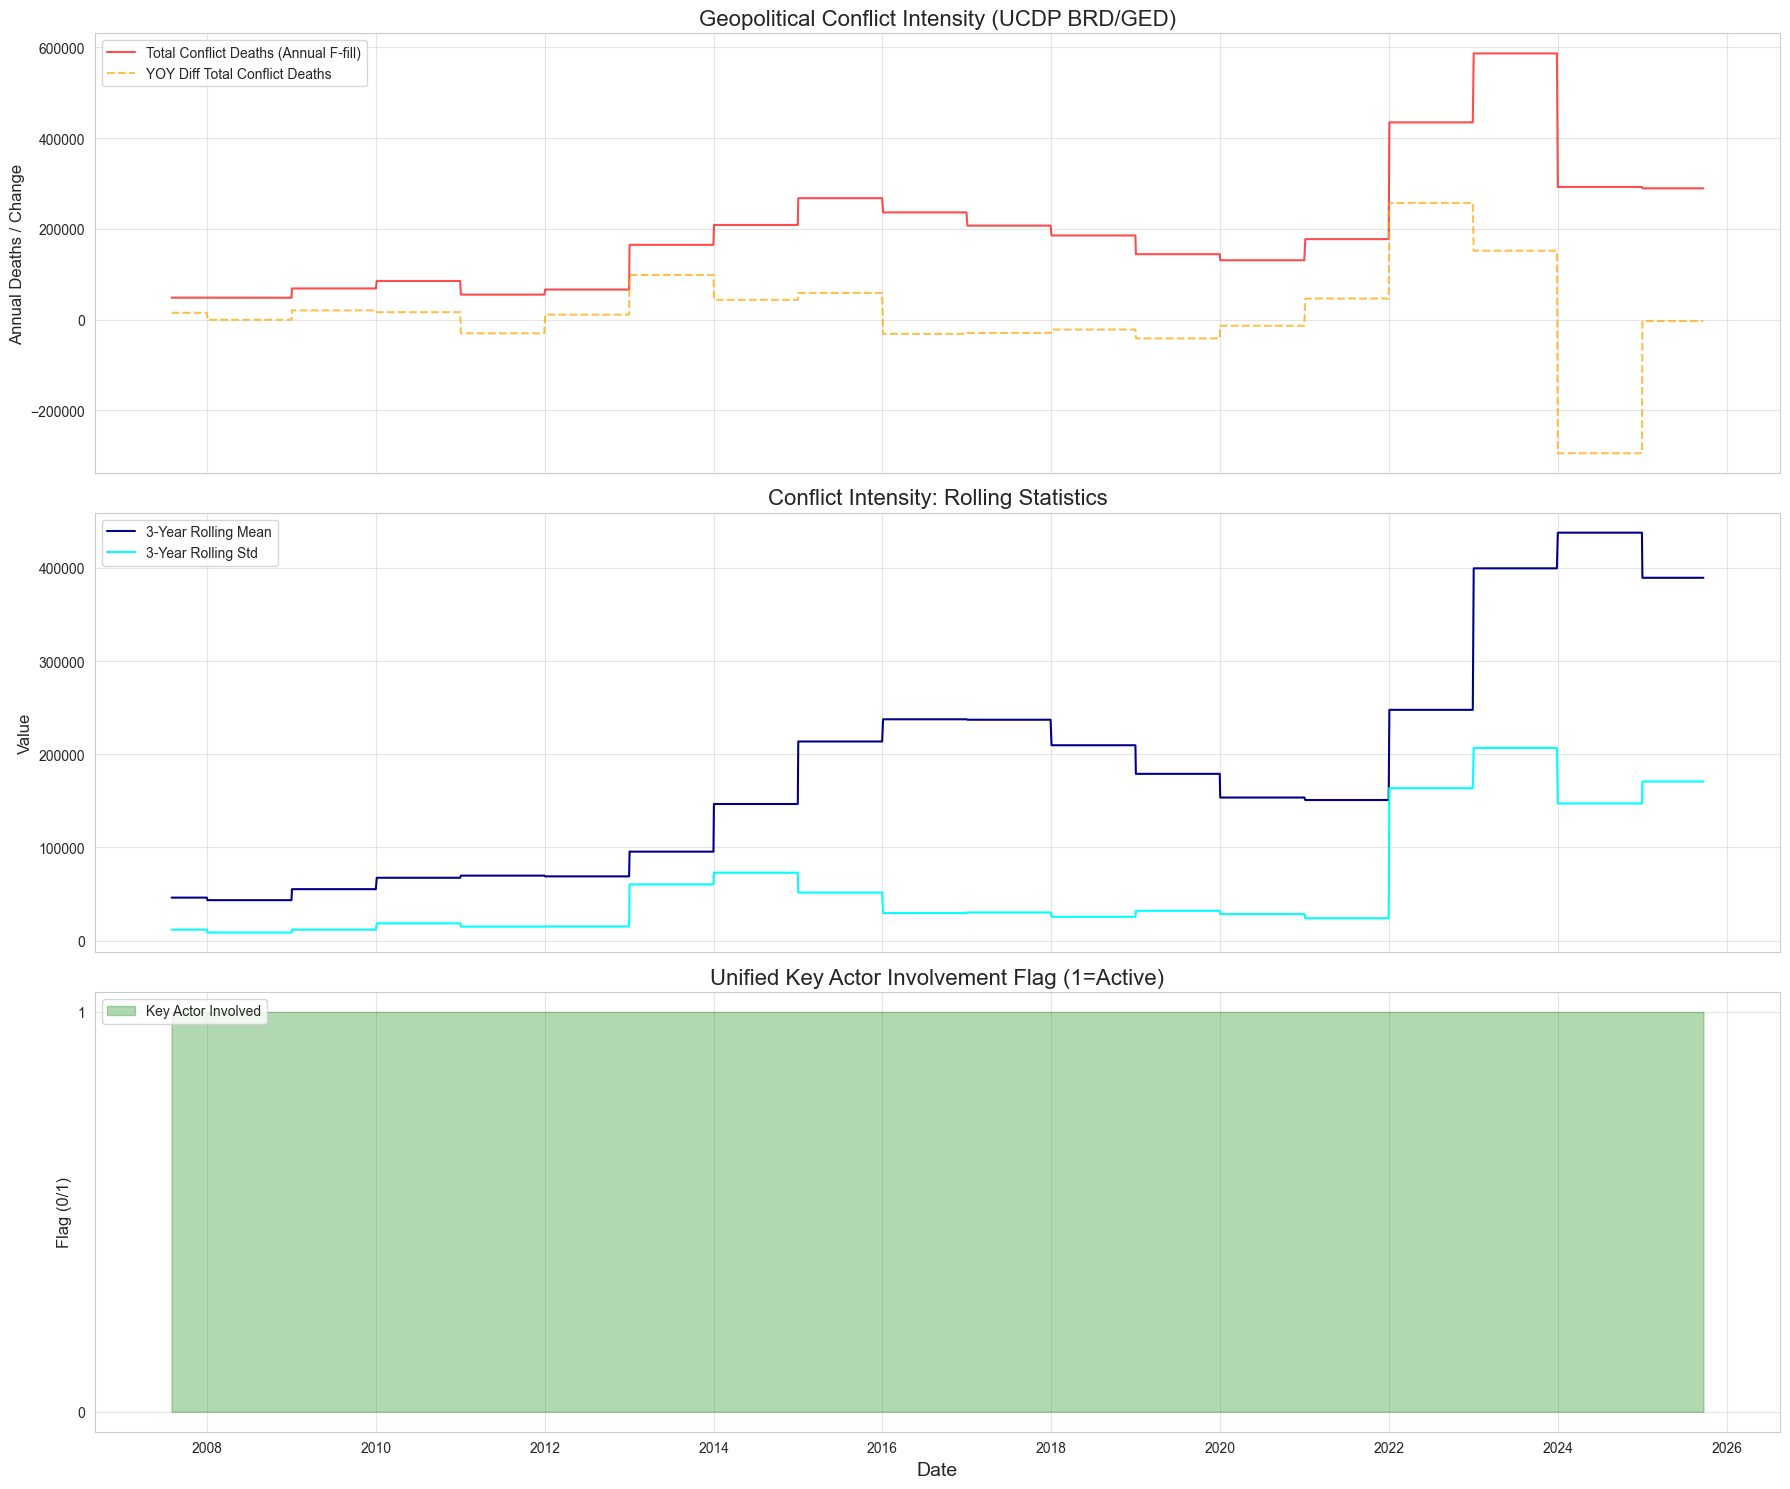

In [11]:
# --- Visualizing Conflict Features with Unified 'flag' ---
print("\n--- Visualizing Conflict Features with Unified 'flag' ---")
fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)

# Plot 1: Total Conflict Deaths and its Year-Over-Year change (No change here)
axes[0].plot(raw_data_aug.index, raw_data_aug['total_best'], label='Total Conflict Deaths (Annual F-fill)', color='red', alpha=0.7)
axes[0].plot(raw_data_aug.index, raw_data_aug['yoy_diff_total_best'], label='YOY Diff Total Conflict Deaths', color='orange', alpha=0.7, linestyle='--')
axes[0].set_title('Geopolitical Conflict Intensity (UCDP BRD/GED)', fontsize=16)
axes[0].set_ylabel('Annual Deaths / Change', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.5)

# Plot 2: Rolling Statistics of Conflict Intensity (No change here)
axes[1].plot(raw_data_aug.index, raw_data_aug['rolling_mean_3y_total_best'], label='3-Year Rolling Mean', color='darkblue')
axes[1].plot(raw_data_aug.index, raw_data_aug['rolling_std_3y_total_best'], label='3-Year Rolling Std', color='cyan')
axes[1].set_title('Conflict Intensity: Rolling Statistics', fontsize=16)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.5)

# Plot 3: The Unified Key Actor Involvement Flag (THIS IS THE ALTERED PART)
# We now use the single 'flag' column instead of 'country_flag'.
axes[2].fill_between(raw_data_aug.index, 0, raw_data_aug['flag'], color='green', alpha=0.3, label='Key Actor Involved')
axes[2].set_title('Unified Key Actor Involvement Flag (1=Active)', fontsize=16)
axes[2].set_ylabel('Flag (0/1)', fontsize=12)
axes[2].set_yticks([0, 1])
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.5)

plt.xlabel('Date', fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
# --- Add GPR features (daily and monthly) ---
def add_gpr_wrapper():
    key_countries = ['USA', 'RUS', 'SAU', 'IRN', 'IRQ']
    return add_gpr_features(raw_data_aug, 
                            gpr_daily_path='datasets/data_gpr_daily_recent.xls',
                            gpr_monthly_path='datasets/data_gpr_export.xls',
                            country_list=key_countries)

raw_data_aug_with_gpr = add_gpr_wrapper()
print("\nDataFrame after adding GPR features:")
print(raw_data_aug_with_gpr.head())


DataFrame after adding GPR features:
            brent_price  wti_price        dxy  gold_price  copper_price  \
Date                                                                      
2007-07-31    77.050003  78.209999  80.769997  666.900024        3.6535   
2007-08-01    75.349998  76.529999  80.870003  663.599976        3.5950   
2007-08-02    75.760002  76.860001  80.709999  664.599976        3.5750   
2007-08-03    74.750000  75.480003  80.180000  672.500000        3.4845   
2007-08-06    71.169998  72.059998  80.250000  671.500000        3.4785   

                  sp500  t3m_yield       nasdaq  10y_yield        vix  \
Date                                                                    
2007-07-31  1455.270020      4.810  2546.270020      4.771  23.520000   
2007-08-01  1465.810059      4.740  2553.870117      4.759  23.670000   
2007-08-02  1472.199951      4.745  2575.979980      4.753  21.219999   
2007-08-03  1433.060059      4.700  2511.250000      4.700  25.160000  


--- Visualizing Geopolitical Risk (GPR) Features ---


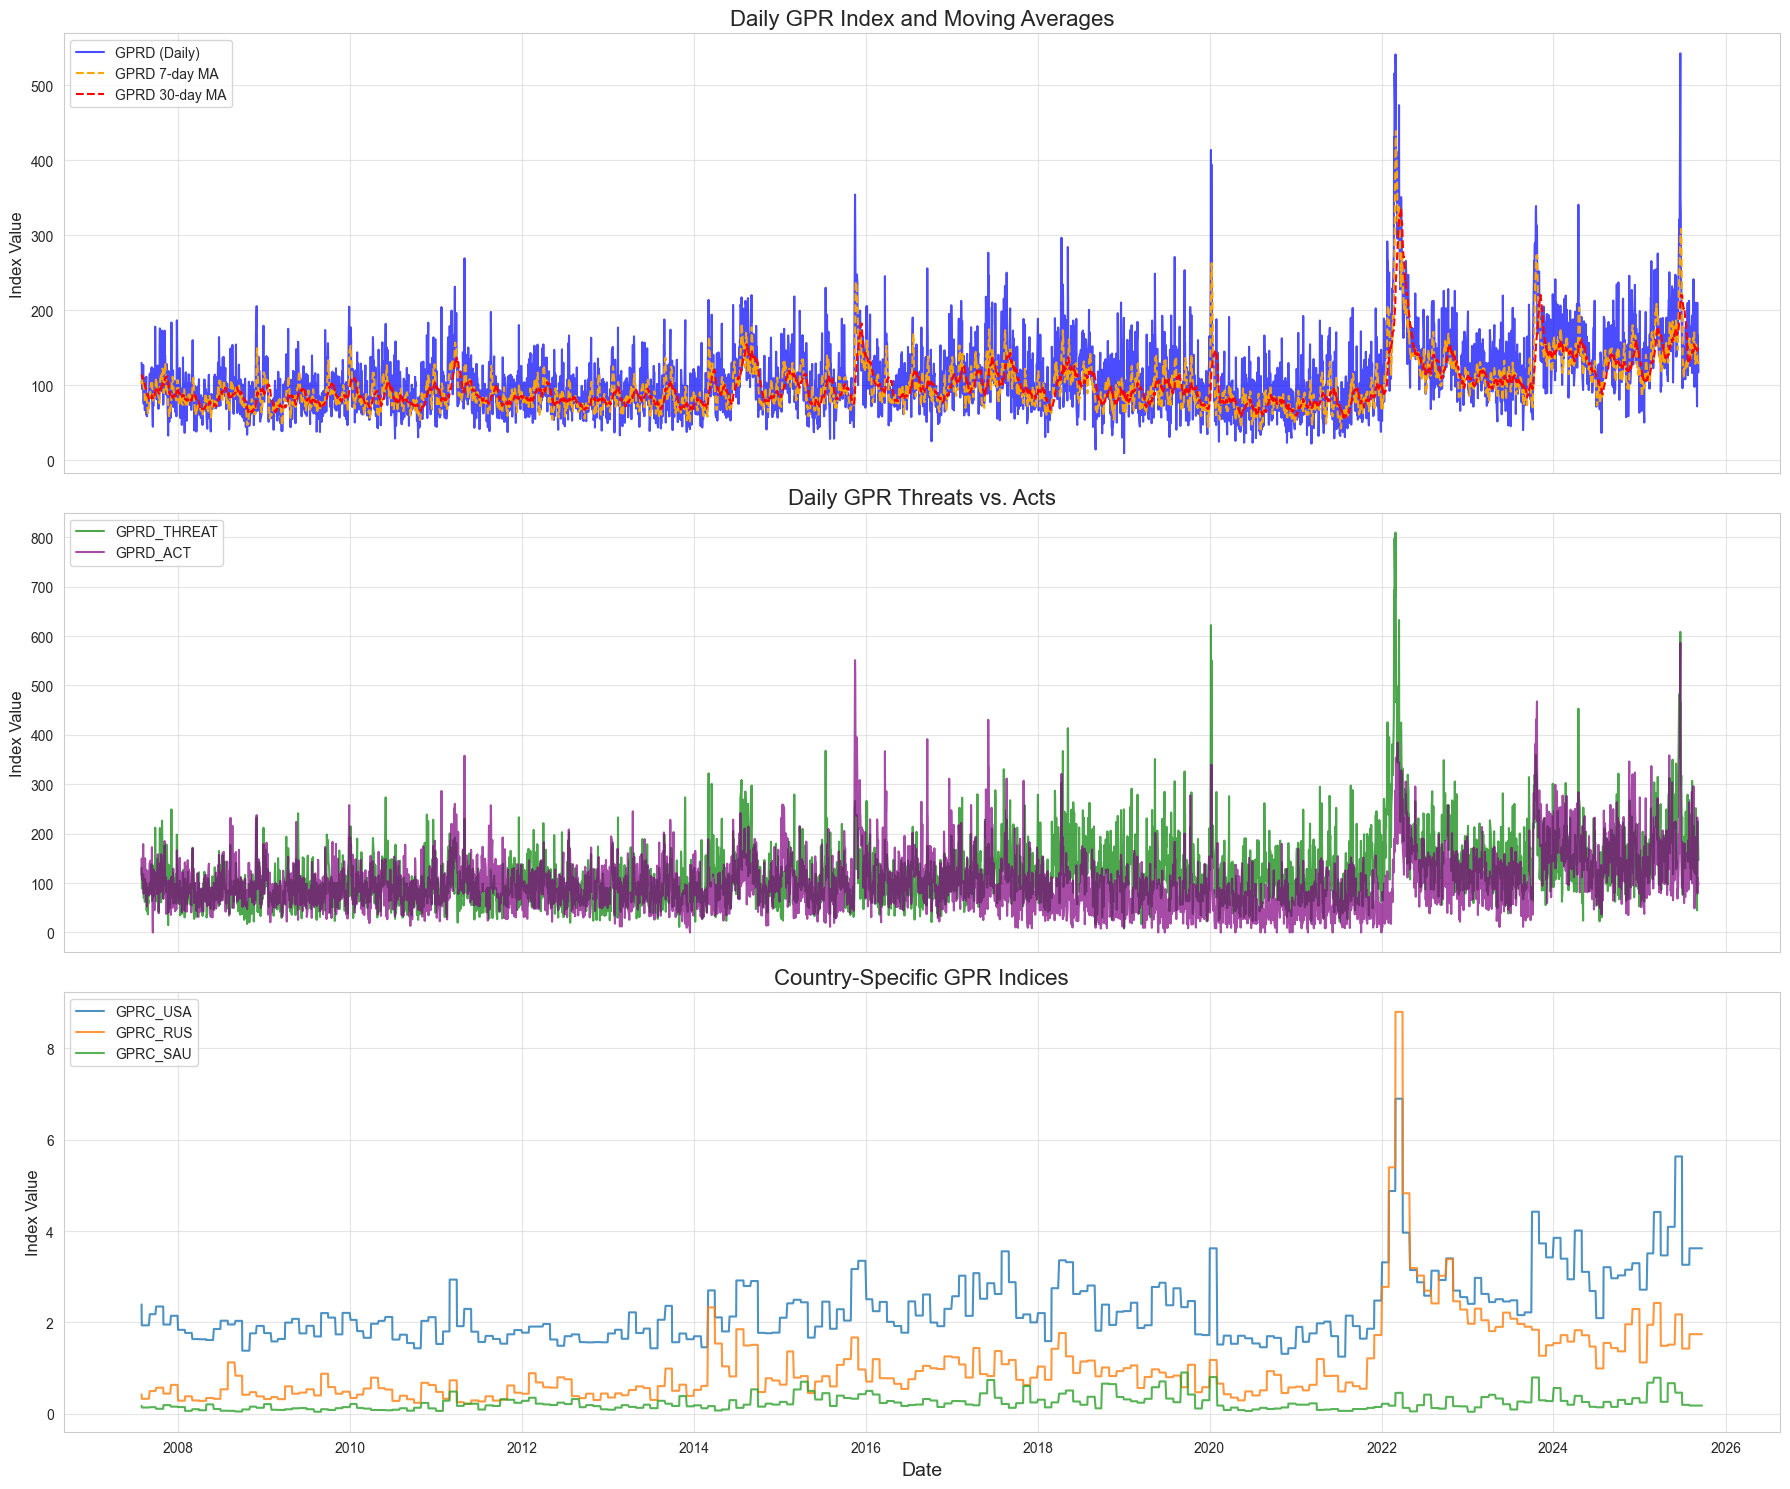

In [13]:
# --- Visualizing GPR features ---
print("\n--- Visualizing Geopolitical Risk (GPR) Features ---")
fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)

# Top panel: Daily GPR and moving averages
axes[0].plot(raw_data_aug_with_gpr.index, raw_data_aug_with_gpr['GPRD'], label='GPRD (Daily)', color='blue', alpha=0.7)
axes[0].plot(raw_data_aug_with_gpr.index, raw_data_aug_with_gpr['GPRD_MA7'], label='GPRD 7-day MA', color='orange', linestyle='--')
axes[0].plot(raw_data_aug_with_gpr.index, raw_data_aug_with_gpr['GPRD_MA30'], label='GPRD 30-day MA', color='red', linestyle='--')
axes[0].set_title('Daily GPR Index and Moving Averages', fontsize=16)
axes[0].set_ylabel('Index Value', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.5)

# Middle panel: Threats vs Acts
axes[1].plot(raw_data_aug_with_gpr.index, raw_data_aug_with_gpr['GPRD_THREAT'], label='GPRD_THREAT', color='green', alpha=0.7)
axes[1].plot(raw_data_aug_with_gpr.index, raw_data_aug_with_gpr['GPRD_ACT'], label='GPRD_ACT', color='purple', alpha=0.7)
axes[1].set_title('Daily GPR Threats vs. Acts', fontsize=16)
axes[1].set_ylabel('Index Value', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.5)

# Bottom panel: Country-specific GPR (up to 3 for clarity)
gprc_cols = [col for col in raw_data_aug_with_gpr.columns if col.startswith('GPRC_')]
for col in gprc_cols[:3]:
    axes[2].plot(raw_data_aug_with_gpr.index, raw_data_aug_with_gpr[col], label=col, linewidth=1.5, alpha=0.8)
axes[2].set_title('Country-Specific GPR Indices', fontsize=16)
axes[2].set_ylabel('Index Value', fontsize=12)
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.5)

plt.xlabel('Date', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# --- Add EPU features ---
raw_data_aug_with_epu = add_daily_epu(raw_data_aug_with_gpr, epu_path='datasets/All_Daily_Policy_Data.csv', lag=1)
print("\nDataFrame after adding EPU features:")
print(raw_data_aug_with_epu.head())


DataFrame after adding EPU features:
            brent_price  wti_price        dxy  gold_price  copper_price  \
Date                                                                      
2007-07-31    77.050003  78.209999  80.769997  666.900024        3.6535   
2007-08-01    75.349998  76.529999  80.870003  663.599976        3.5950   
2007-08-02    75.760002  76.860001  80.709999  664.599976        3.5750   
2007-08-03    74.750000  75.480003  80.180000  672.500000        3.4845   
2007-08-06    71.169998  72.059998  80.250000  671.500000        3.4785   

                  sp500  t3m_yield       nasdaq  10y_yield        vix  \
Date                                                                    
2007-07-31  1455.270020      4.810  2546.270020      4.771  23.520000   
2007-08-01  1465.810059      4.740  2553.870117      4.759  23.670000   
2007-08-02  1472.199951      4.745  2575.979980      4.753  21.219999   
2007-08-03  1433.060059      4.700  2511.250000      4.700  25.160000  


--- Visualizing Economic Policy Uncertainty (EPU) ---


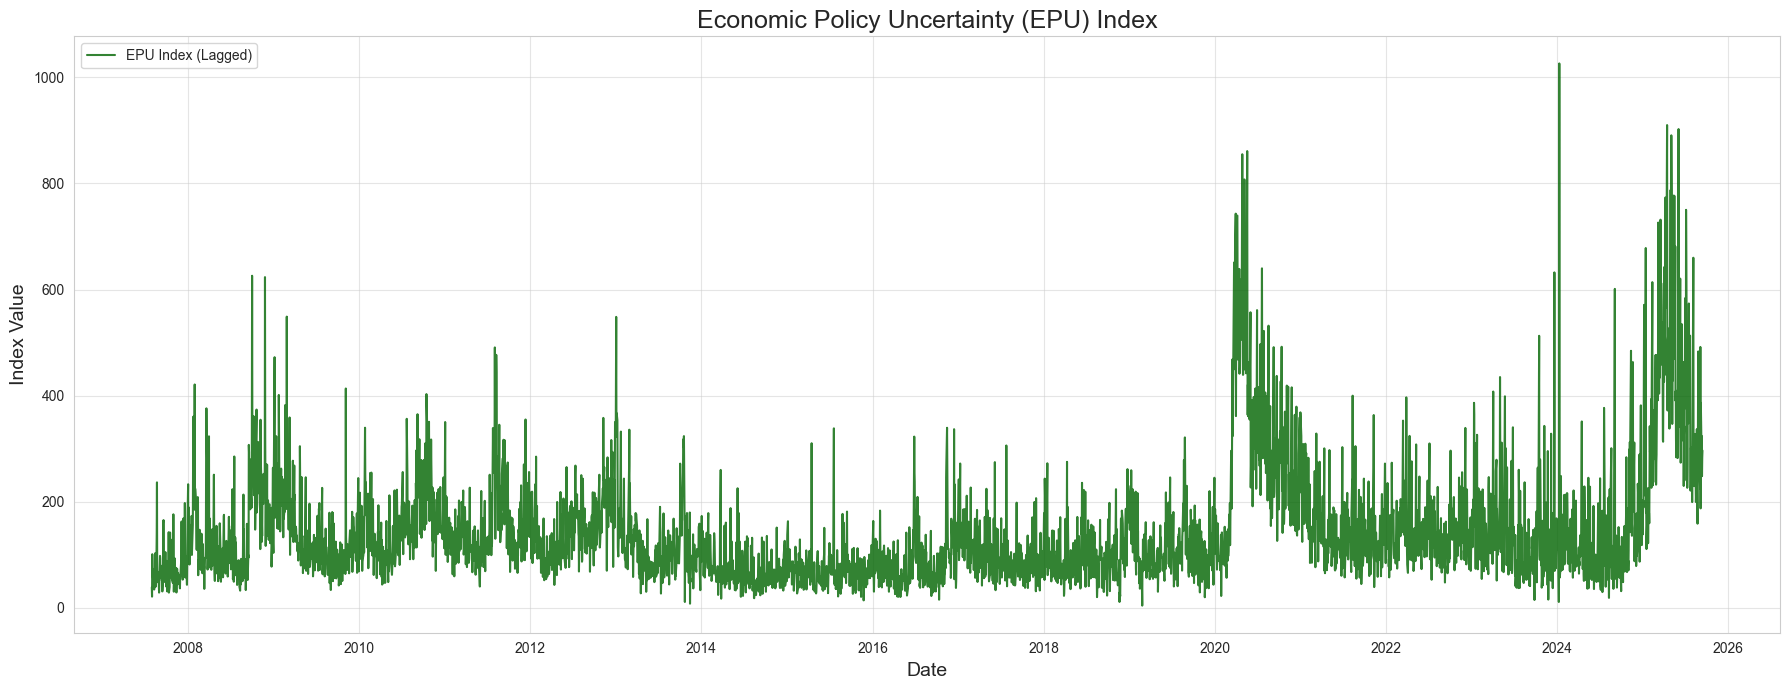

In [15]:
# --- Visualize EPU ---
print("\n--- Visualizing Economic Policy Uncertainty (EPU) ---")
plt.figure(figsize=(18, 7))
plt.plot(raw_data_aug_with_epu.index, raw_data_aug_with_epu['EPU_index'], label='EPU Index (Lagged)', color='darkgreen', alpha=0.8)
plt.title('Economic Policy Uncertainty (EPU) Index', fontsize=18)
plt.ylabel('Index Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
# --- Add BDI features ---
raw_data_aug_with_bdi = add_bdi_prices(raw_data_aug_with_epu, bdi_path='datasets/koyfin_2025-09-15.csv', lag=1)
print("\nDataFrame after adding BDI features:")
print(raw_data_aug_with_bdi.head())


DataFrame after adding BDI features:
            brent_price  wti_price        dxy  gold_price  copper_price  \
Date                                                                      
2007-07-31    77.050003  78.209999  80.769997  666.900024        3.6535   
2007-08-01    75.349998  76.529999  80.870003  663.599976        3.5950   
2007-08-02    75.760002  76.860001  80.709999  664.599976        3.5750   
2007-08-03    74.750000  75.480003  80.180000  672.500000        3.4845   
2007-08-06    71.169998  72.059998  80.250000  671.500000        3.4785   

                  sp500  t3m_yield       nasdaq  10y_yield        vix  \
Date                                                                    
2007-07-31  1455.270020      4.810  2546.270020      4.771  23.520000   
2007-08-01  1465.810059      4.740  2553.870117      4.759  23.670000   
2007-08-02  1472.199951      4.745  2575.979980      4.753  21.219999   
2007-08-03  1433.060059      4.700  2511.250000      4.700  25.160000  


--- Visualizing Baltic Dry Index (BDI) ---


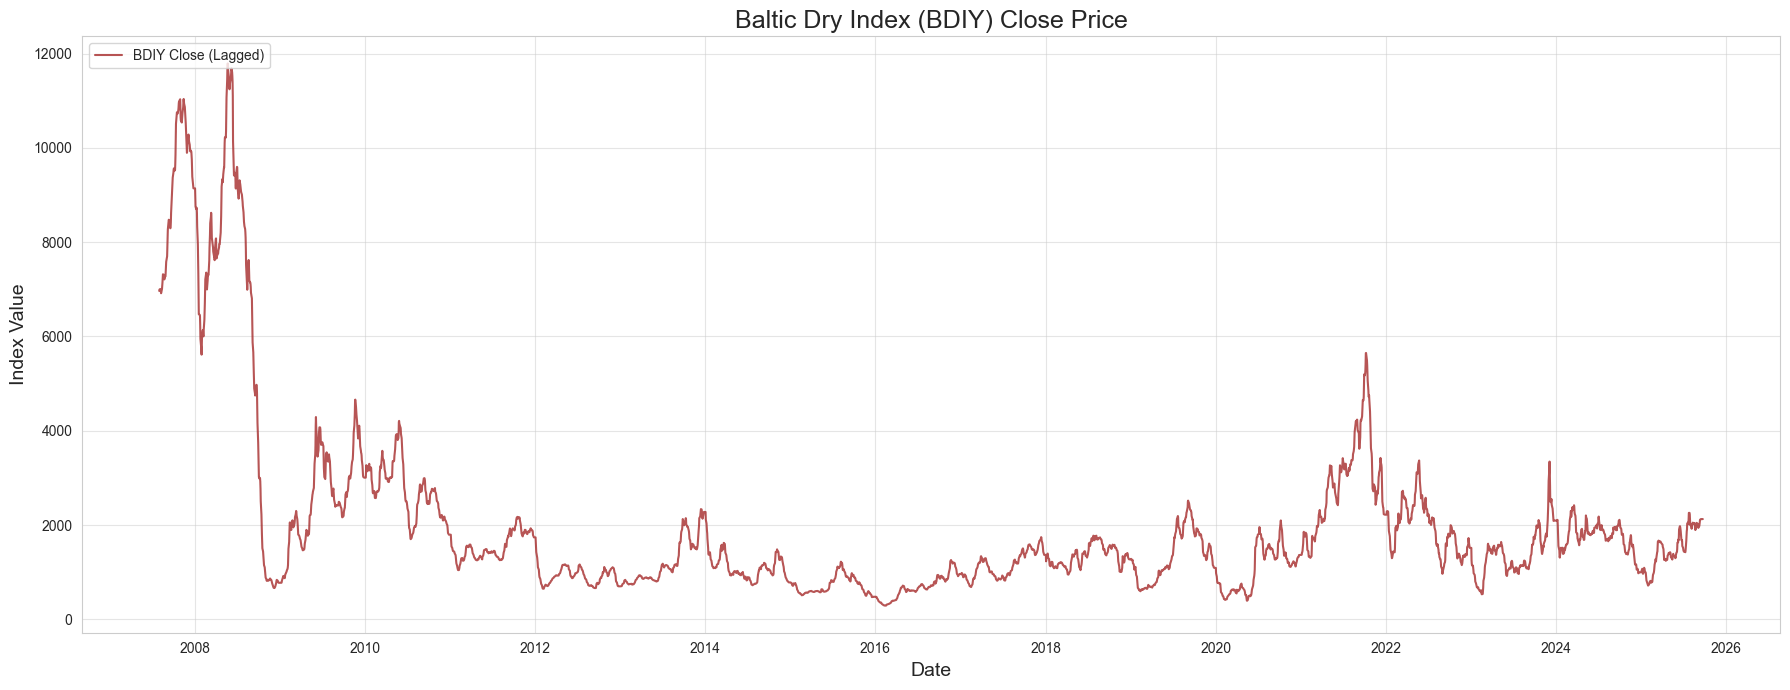

In [30]:
# --- Visualize BDI ---
print("\n--- Visualizing Baltic Dry Index (BDI) ---")
plt.figure(figsize=(18, 7))
plt.plot(raw_data_aug_with_bdi.index, raw_data_aug_with_bdi['BDIY Close'], label='BDIY Close (Lagged)', color='brown', alpha=0.8)
plt.title('Baltic Dry Index (BDIY) Close Price', fontsize=18)
plt.ylabel('Index Value', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
# --- Fetch & integrate weather data ---
start_date = raw_data_aug.index.min().strftime('%Y-%m-%d')
end_date = raw_data_aug.index.max().strftime('%Y-%m-%d')
cities_to_fetch = ['Houston', 'Dallas', 'New York', 'Riyadh', 'London']

weather_data = get_weather_data_for_analysis(start_date, end_date, cities=cities_to_fetch)

raw_data_final = pd.DataFrame()
if not weather_data.empty:
    raw_data_final = integrate_weather_with_oil_data(raw_data_aug_with_bdi, weather_data)
    print("\nWeather features added. Final DataFrame head:")
    print(raw_data_final.head())
else:
    print("\nWeather data fetch failed. Proceeding without weather features.")
    raw_data_final = raw_data_aug_with_bdi


Weather features added. Final DataFrame head:
            brent_price  wti_price        dxy  gold_price  copper_price  \
Date                                                                      
2007-07-31    77.050003  78.209999  80.769997  666.900024        3.6535   
2007-08-01    75.349998  76.529999  80.870003  663.599976        3.5950   
2007-08-02    75.760002  76.860001  80.709999  664.599976        3.5750   
2007-08-03    74.750000  75.480003  80.180000  672.500000        3.4845   
2007-08-06    71.169998  72.059998  80.250000  671.500000        3.4785   

                  sp500  t3m_yield       nasdaq  10y_yield        vix  \
Date                                                                    
2007-07-31  1455.270020      4.810  2546.270020      4.771  23.520000   
2007-08-01  1465.810059      4.740  2553.870117      4.759  23.670000   
2007-08-02  1472.199951      4.745  2575.979980      4.753  21.219999   
2007-08-03  1433.060059      4.700  2511.250000      4.700  25

In [19]:
# --- NA checks and cleanup steps (no preprocessing changes applied) ---
for column in raw_data_final.columns:
    print(column, raw_data_final[column].isna().sum())

brent_price 0
wti_price 0
dxy 0
gold_price 0
copper_price 0
sp500 0
t3m_yield 0
nasdaq 0
10y_yield 0
vix 0
sp500_volatility 0
flag 0
total_best 0
yoy_diff_total_best 0
yoy_pct_total_best 0
rolling_mean_3y_total_best 0
rolling_std_3y_total_best 0
lag1_total_best 0
lag2_total_best 0
GPRD 11
GPRD_ACT 11
GPRD_THREAT 11
GPRD_MA7 11
GPRD_MA30 11
GPR 0
GPRT 0
GPRA 0
GPRC_USA 0
GPRC_RUS 0
GPRC_SAU 0
EPU_index 7
BDIY Date 1
BDIY Open 1
BDIY Low 1
BDIY High 1
BDIY Close 1
temp_mean_c_mean 1
temp_mean_c_std 1
temp_mean_c_min 1
temp_mean_c_max 1
precip_mm_sum 0
precip_mm_max 1
wind_max_ms_mean 1
wind_max_ms_max 1


In [20]:
raw_data_final.ffill(inplace=True)
columns_to_drop = ['BDIY Date', 'BDIY Open', 'BDIY High', 'BDIY Low']
raw_data_final = raw_data_final.drop(columns=columns_to_drop, errors='ignore')
raw_data_final

,brent_price,wti_price,dxy,gold_price,copper_price,sp500,t3m_yield,nasdaq,10y_yield,vix,sp500_volatility,flag,total_best,yoy_diff_total_best,yoy_pct_total_best,rolling_mean_3y_total_best,rolling_std_3y_total_best,lag1_total_best,lag2_total_best,GPRD,GPRD_ACT,GPRD_THREAT,GPRD_MA7,GPRD_MA30,GPR,GPRT,GPRA,GPRC_USA,GPRC_RUS,GPRC_SAU,EPU_index,BDIY Close,temp_mean_c_mean,temp_mean_c_std,temp_mean_c_min,temp_mean_c_max,precip_mm_sum,precip_mm_max,wind_max_ms_mean,wind_max_ms_max
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-31,77.050003,78.209999,80.769997,666.900024,3.6535,1455.270020,4.810,2546.270020,4.771,23.520000,0.202040,1,48517.0,15154.0,0.454216,46117.000000,11739.459783,33363.0,56471.0,129.904617,115.872681,130.760757,102.086182,114.757286,112.346252,103.263405,127.134682,2.392128,0.424044,0.174797,38.67,NaN,27.08,8.572456,15.3,39.3,9.3,9.2,12.52,20.2
2007-08-01,75.349998,76.529999,80.870003,663.599976,3.5950,1465.810059,4.740,2553.870117,4.759,23.670000,0.164231,1,48517.0,15154.0,0.454216,46117.000000,11739.459783,33363.0,56471.0,124.139610,149.811707,108.658928,106.737961,113.771431,83.173203,73.125740,100.148254,1.936078,0.326911,0.136478,21.01,6967.0,27.12,7.283337,17.0,37.5,9.5,6.1,11.80,21.6
2007-08-02,75.760002,76.860001,80.709999,664.599976,3.5750,1472.199951,4.745,2575.979980,4.753,21.219999,0.139895,1,48517.0,15154.0,0.454216,46117.000000,11739.459783,33363.0,56471.0,95.069206,106.623642,88.934647,102.557518,111.832916,83.173203,73.125740,100.148254,1.936078,0.326911,0.136478,100.97,6993.0,27.00,7.505998,16.3,37.5,20.6,19.1,11.24,14.2
2007-08-03,74.750000,75.480003,80.180000,672.500000,3.4845,1433.060059,4.700,2511.250000,4.700,25.160000,0.245806,1,48517.0,15154.0,0.454216,46117.000000,11739.459783,33363.0,56471.0,122.339142,143.853287,114.770996,104.598534,110.588005,83.173203,73.125740,100.148254,1.936078,0.326911,0.136478,71.02,7000.0,27.42,7.334644,17.0,37.7,1.8,1.5,13.54,17.4
2007-08-06,71.169998,72.059998,80.250000,671.500000,3.4785,1467.670044,4.715,2547.330078,4.731,22.940001,0.277559,1,48517.0,15154.0,0.454216,46117.000000,11739.459783,33363.0,56471.0,104.241646,123.165367,89.890564,106.055428,108.930405,83.173203,73.125740,100.148254,1.936078,0.326911,0.136478,49.15,7007.0,27.22,7.077217,17.3,36.8,3.7,3.3,15.52,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-17,67.949997,64.050003,96.870003,3681.800049,4.5710,6600.350098,3.868,22261.330078,4.076,15.720000,0.087770,1,289339.0,-2959.0,-0.010123,389388.666667,170734.947185,292298.0,586529.0,117.259033,97.415085,146.256836,131.308105,145.436005,135.999268,156.925735,121.951042,3.623188,1.742387,0.179124,296.41,2126.0,25.64,7.712522,16.2,34.6,7.9,6.8,15.32,24.4
2025-09-18,67.440002,63.570000,97.349998,3643.699951,4.5410,6631.959961,3.880,22470.720703,4.104,15.700000,0.088975,1,289339.0,-2959.0,-0.010123,389388.666667,170734.947185,292298.0,586529.0,117.259033,97.415085,146.256836,131.308105,145.436005,135.999268,156.925735,121.951042,3.623188,1.742387,0.179124,296.41,2126.0,26.68,6.776946,18.6,35.8,0.3,0.1,12.80,21.9
2025-09-19,66.680000,62.680000,97.639999,3671.500000,4.5690,6664.359863,3.878,22631.480469,4.139,15.450000,0.089515,1,289339.0,-2959.0,-0.010123,389388.666667,170734.947185,292298.0,586529.0,117.259033,97.415085,146.256836,131.308105,145.436005,135.999268,156.925735,121.951042,3.623188,1.742387,0.179124,296.41,2126.0,26.84,7.050035,18.9,37.6,13.2,13.0,13.04,19.1


In [21]:
# --- Analysis: build df_analysis with engineered stationary features (no preprocessing beyond transformations) ---
# Ensure raw_data_final is available from previous blocks
if 'raw_data_final' not in locals():
    print("WARNING: raw_data_final not found. Please ensure all previous blocks were executed correctly.")
    # Attempt to use raw_data_aug as a fallback if raw_data_final somehow wasn't created
    raw_data_final = raw_data_aug.copy() 

df = raw_data_final.copy() # Use the fully merged dataframe

df_analysis = pd.DataFrame(index=df.index)

# 1. Create the Target Variable (y)
df_analysis['wti_price_logret'] = np.log(df['wti_price']).diff()

# 2. Create Engineered Spreads and their differences
df_analysis['brent_wti_spread'] = df['brent_price'] - df['wti_price']
df_analysis['brent_wti_spread_diff'] = df_analysis['brent_wti_spread'].diff() # Difference the spread itself

df_analysis['yield_curve_10y_3m'] = df['10y_yield'] - df['t3m_yield']
df_analysis['yield_curve_10y_3m_diff'] = df_analysis['yield_curve_10y_3m'].diff() # Difference the yield curve

# 3. Create Stationary Features (X)
# Log returns for price-like series
for col in ['sp500', 'gold_price', 'copper_price', 'BDIY Close']:
    if col in df.columns: # Check if original column exists
        df_analysis[f'{col}_logret'] = np.log(df[col]).diff()

# Differences for indices and rates
for col in ['dxy', 'vix', 'GPRD', 'EPU_index']:
    if col in df.columns: # Check if original column exists
        df_analysis[f'{col}_diff'] = df[col].diff()

# Keep Annual Conflict Features As-Is (they are already step-wise or represent change)
# Fill NaNs with 0 where appropriate for these flags/differences if they didn't exist before
conflict_cols_to_keep = [
    'yoy_diff_total_best', 'rolling_mean_3y_total_best', 'rolling_std_3y_total_best', 'country_flag',
    'side_a_flag', 'side_b_flag' # Keeping flags as they are binary indicators
]
for col in conflict_cols_to_keep:
    if col in df.columns:
        df_analysis[col] = df[col].fillna(0) # Fill 0 for non-existent conflict periods

# Add GPRC (country-specific) features - differenced
gprc_cols = [c for c in df.columns if 'GPRC_' in c]
for col in gprc_cols:
    df_analysis[f'{col}_diff'] = df[col].diff()

# Add Weather Features (Differenced)
# It's better to calculate HDD/CDD, but for now we'll difference the mean temp and other aggregates
weather_agg_cols = [col for col in df.columns if 'temp_mean_c_' in col or 'precip_mm_' in col or 'wind_max_ms_' in col]
for col in weather_agg_cols:
    if col in df.columns:
        df_analysis[f'{col}_diff'] = df[col].diff()

# Drop any initial NaNs created by transformations
df_analysis = df_analysis.dropna()

print("\nFinal df_analysis head with all stationary and engineered features:")
print(df_analysis.head())
print(f"df_analysis shape: {df_analysis.shape}")


Final df_analysis head with all stationary and engineered features:
            wti_price_logret  brent_wti_spread  brent_wti_spread_diff  \
Date                                                                    
2007-08-02          0.004303         -1.099998               0.080002   
2007-08-03         -0.018118         -0.730003               0.369995   
2007-08-06         -0.046369         -0.889999              -0.159996   
2007-08-07          0.004983         -0.619995               0.270004   
2007-08-08         -0.003735         -1.160004              -0.540009   

            yield_curve_10y_3m  yield_curve_10y_3m_diff  sp500_logret  \
Date                                                                    
2007-08-02               0.008                   -0.011      0.004350   
2007-08-03               0.000                   -0.008     -0.026946   
2007-08-06               0.016                    0.016      0.023864   
2007-08-07              -0.042                   -0.05


--- Performing Stationarity Checks on Key Transformed Features ---


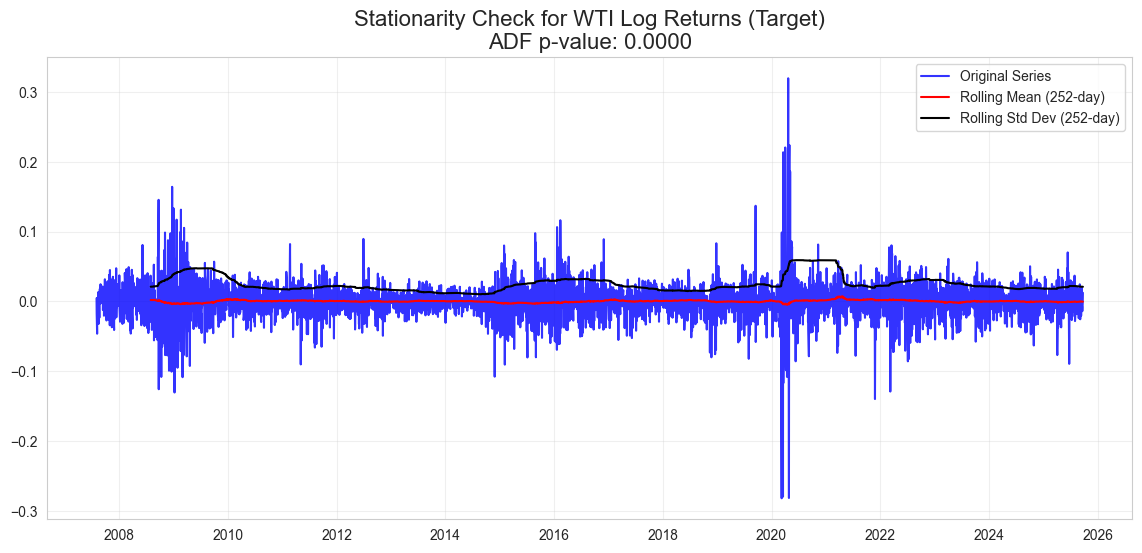

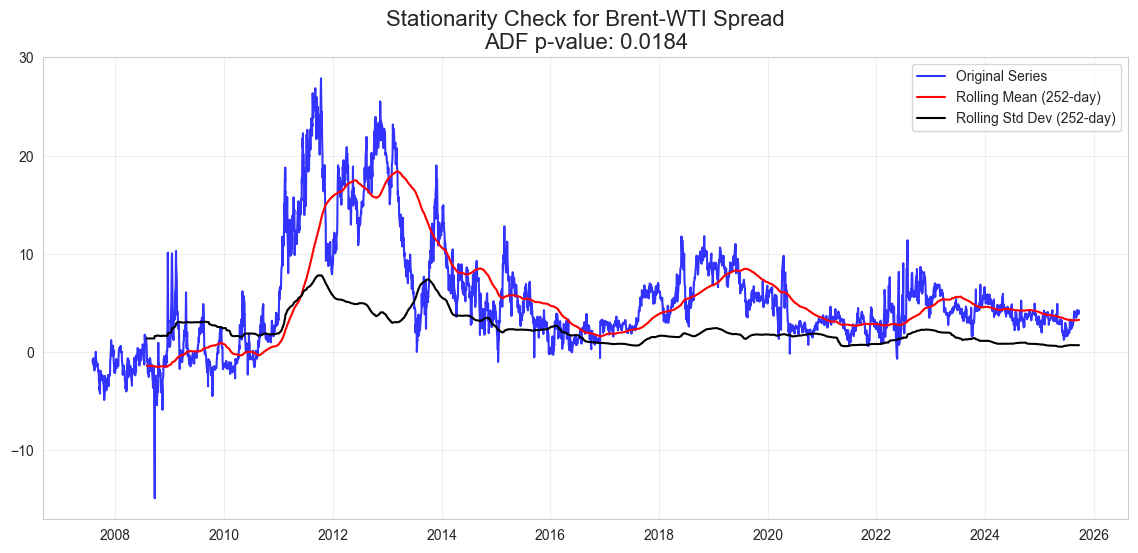

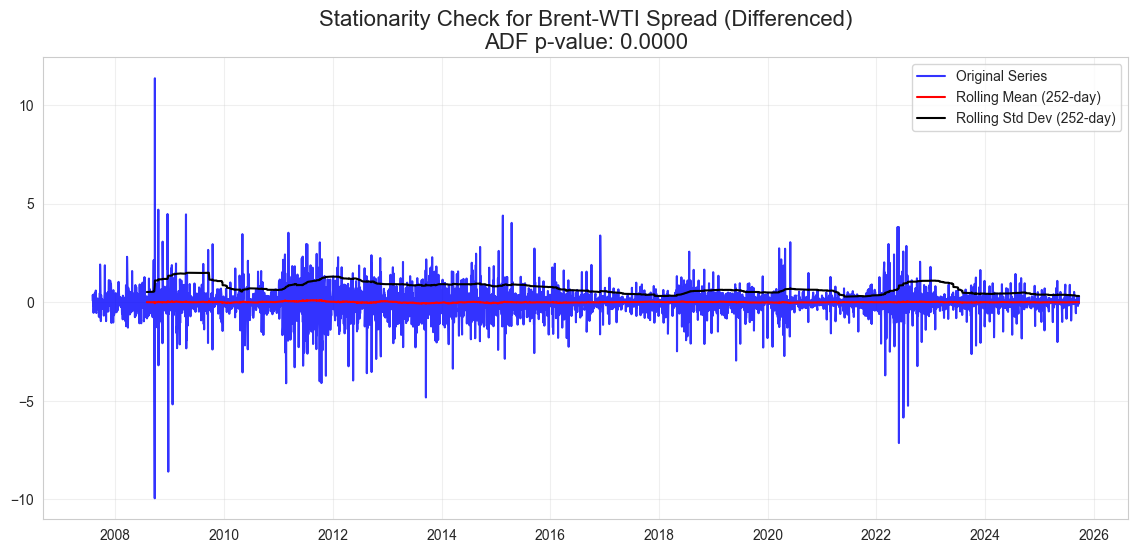

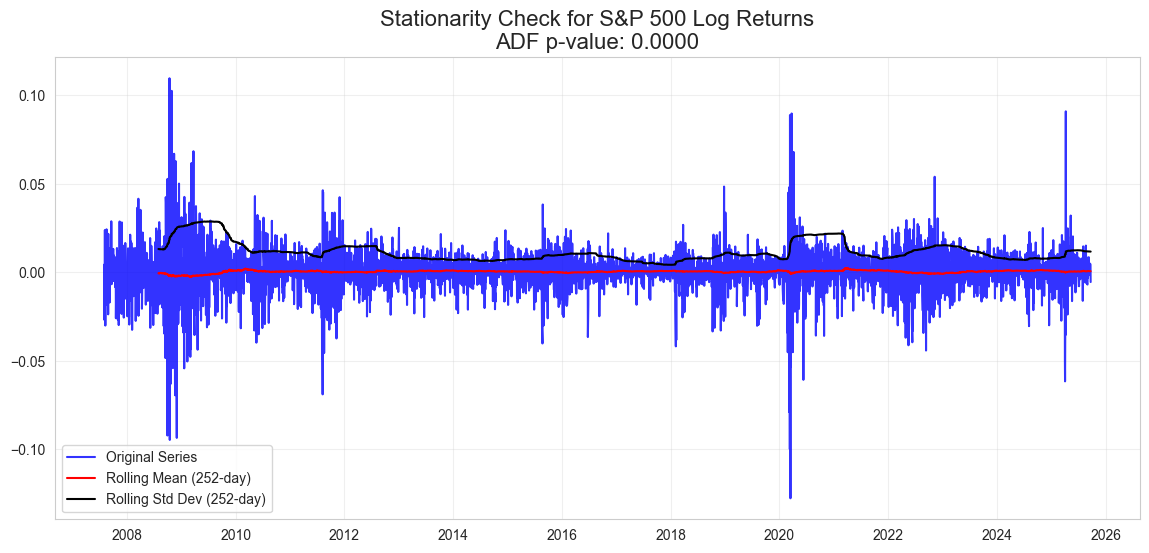

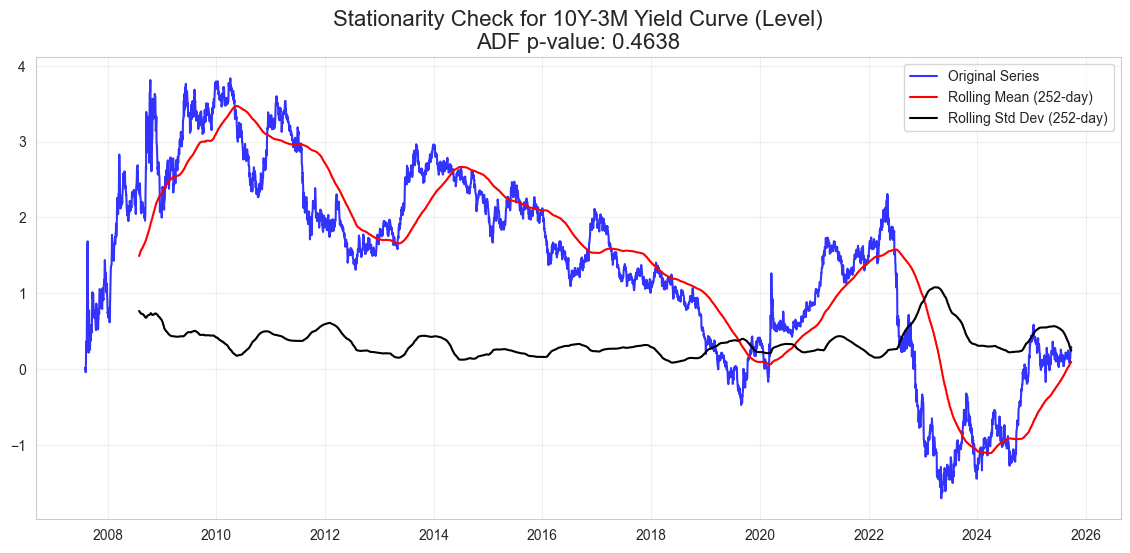

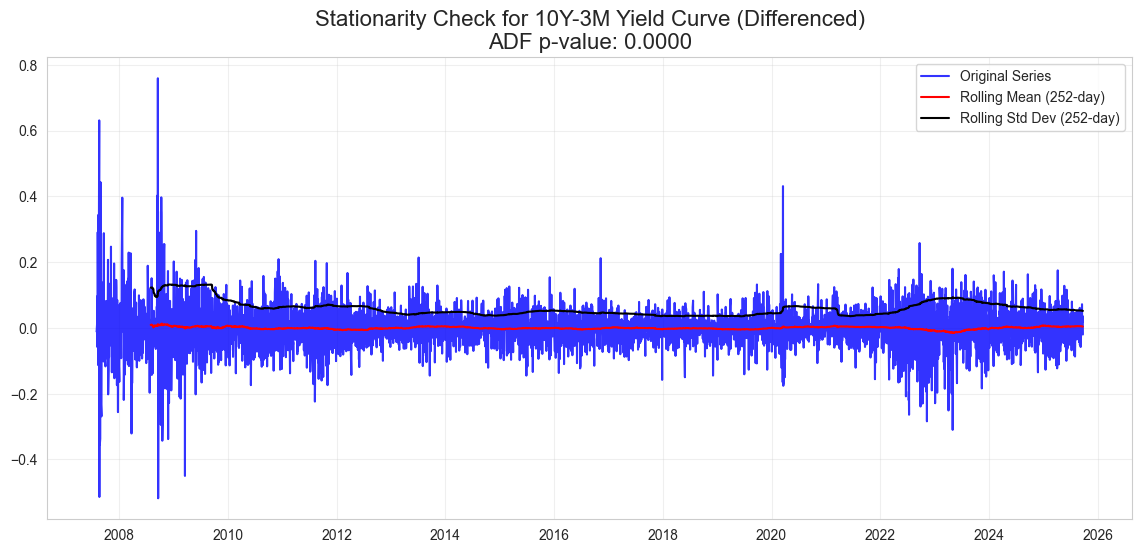

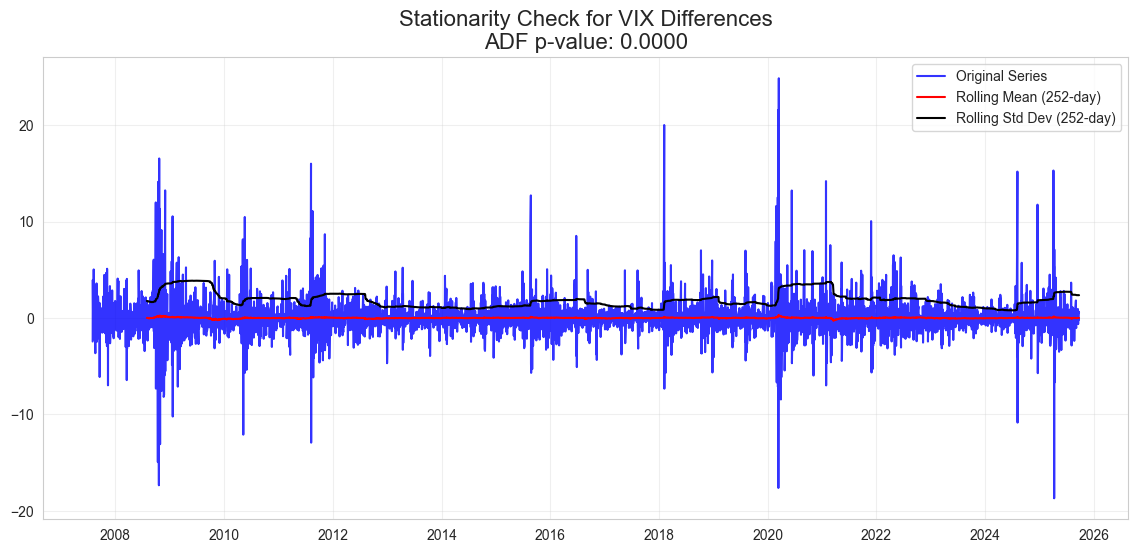

In [22]:
# --- Stationarity checks & plotting ---
print("\n--- Performing Stationarity Checks on Key Transformed Features ---")

# Check WTI Log Returns (your target)
plot_stationarity_check(df_analysis['wti_price_logret'], 'WTI Log Returns (Target)')

# Check Brent-WTI Spread (new engineered feature)
plot_stationarity_check(df_analysis['brent_wti_spread'], 'Brent-WTI Spread')
plot_stationarity_check(df_analysis['brent_wti_spread_diff'], 'Brent-WTI Spread (Differenced)')

# Check S&P 500 Log Returns
plot_stationarity_check(df_analysis['sp500_logret'], 'S&P 500 Log Returns')

# Check 10Y-3M Yield Curve (engineered spread)
plot_stationarity_check(df_analysis['yield_curve_10y_3m'], '10Y-3M Yield Curve (Level)')
plot_stationarity_check(df_analysis['yield_curve_10y_3m_diff'], '10Y-3M Yield Curve (Differenced)')

# Check VIX Differences
plot_stationarity_check(df_analysis['vix_diff'], 'VIX Differences')


--- Correlation Matrix of Stationary Features ---


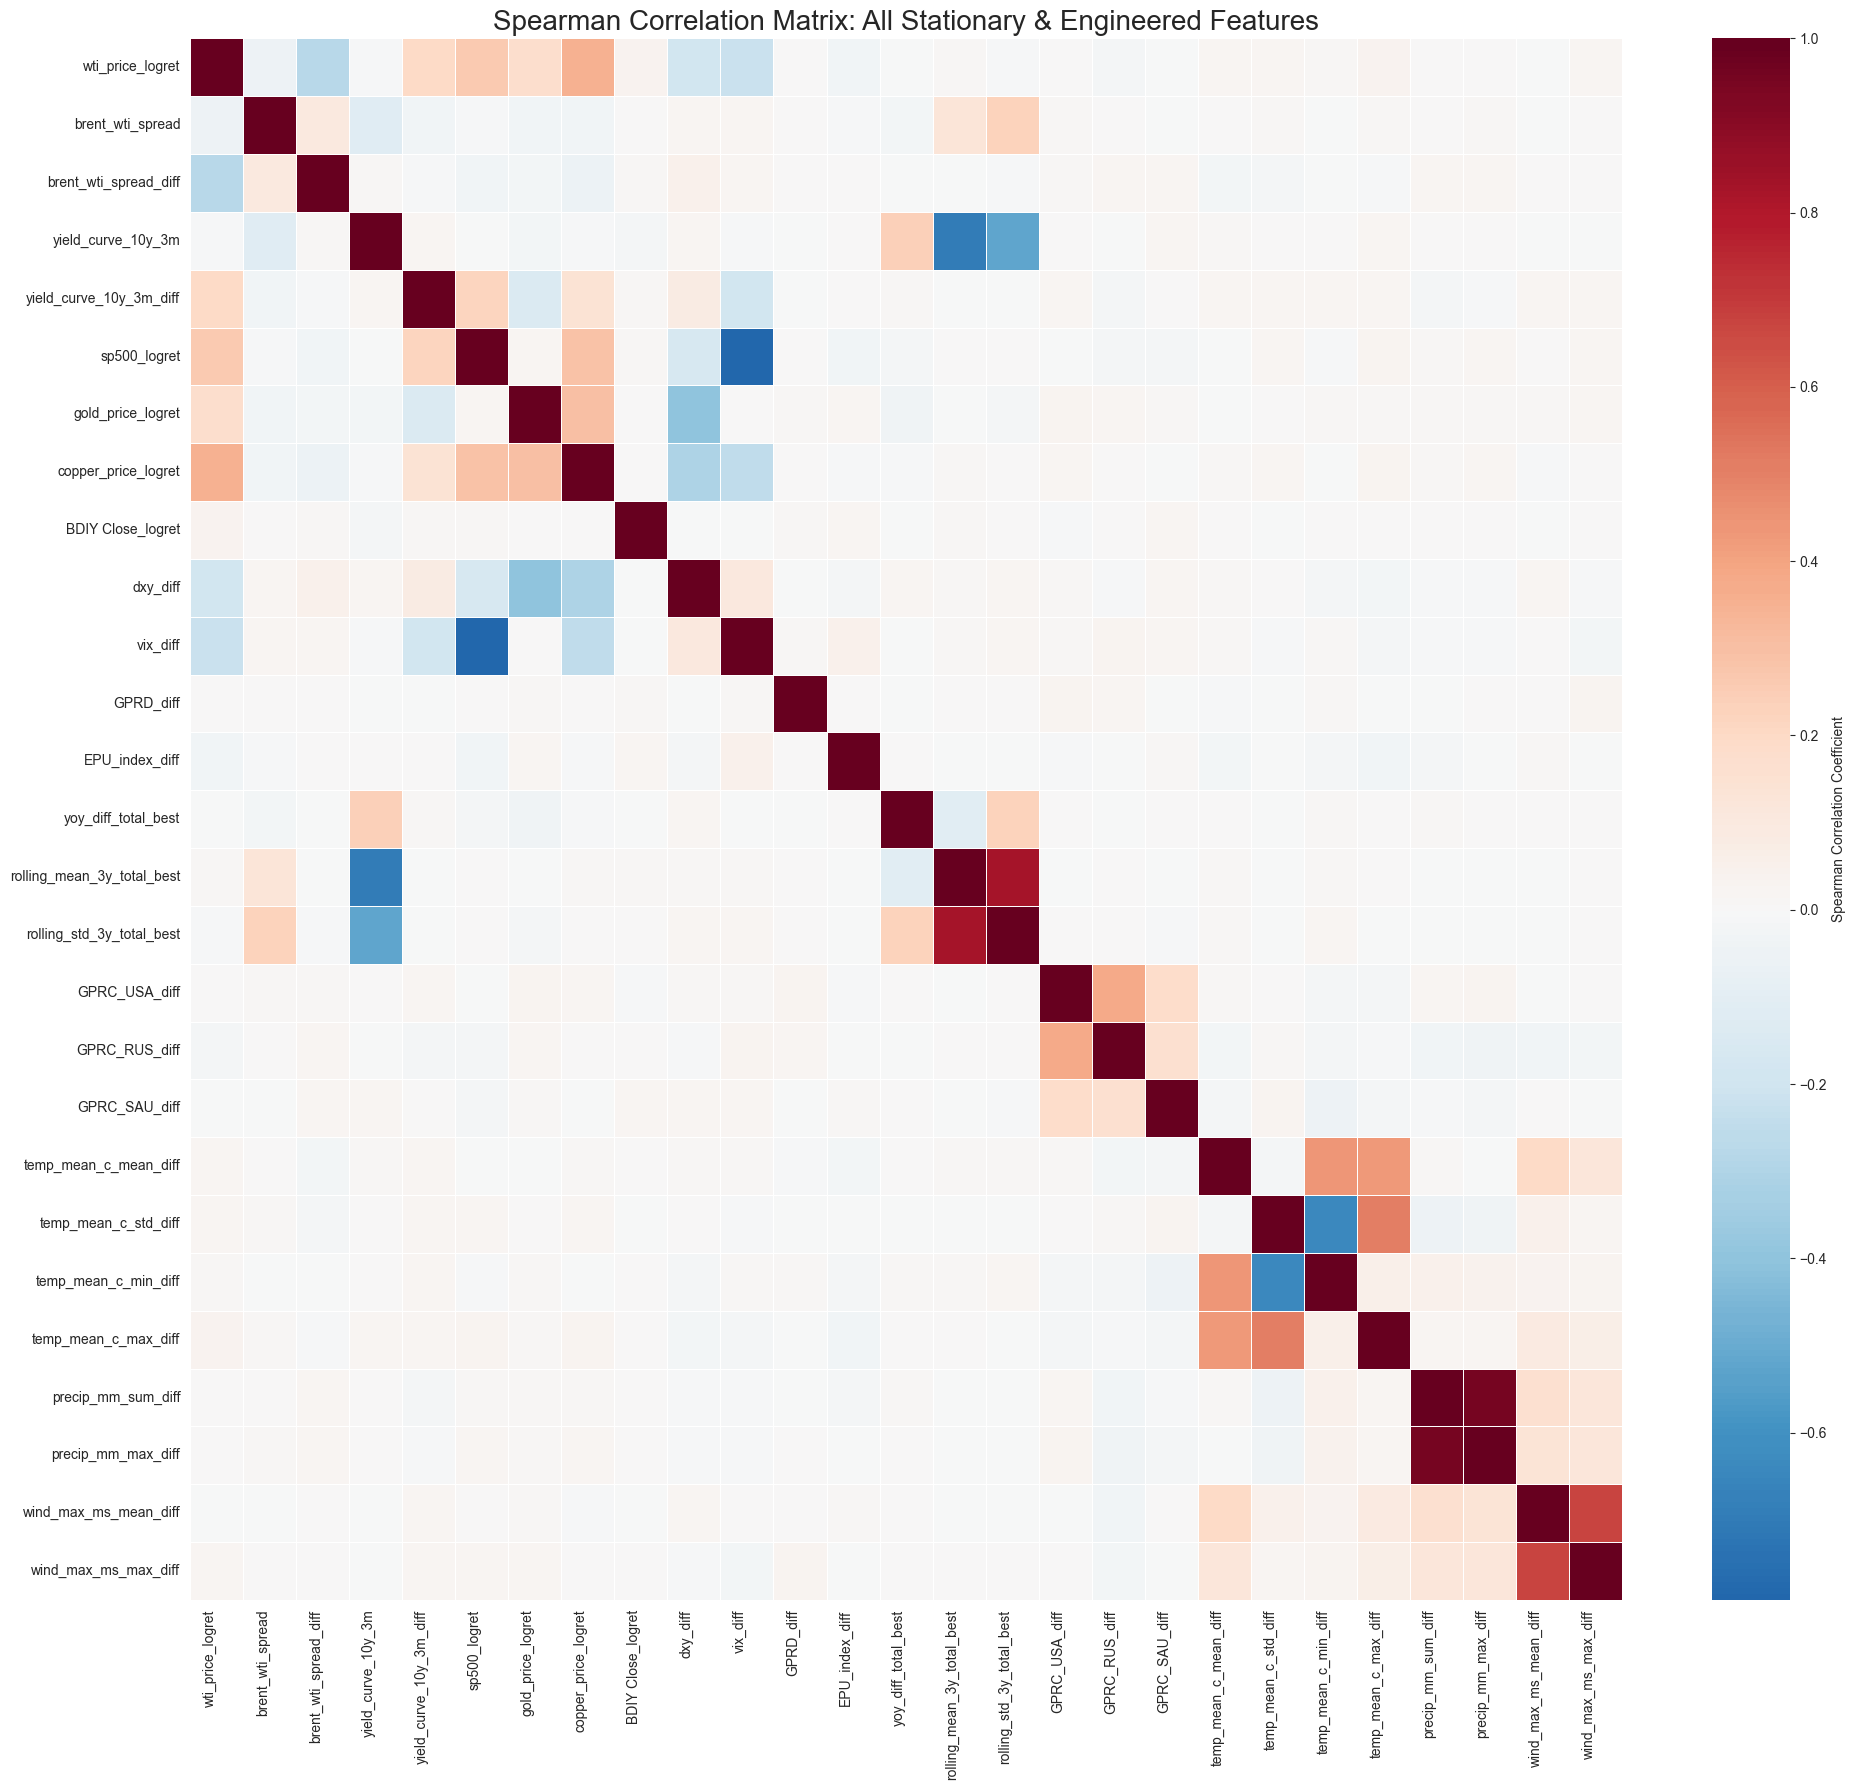


Top correlations with WTI Log Returns:
copper_price_logret        0.353991
sp500_logret               0.261678
yield_curve_10y_3m_diff    0.199177
gold_price_logret          0.180482
BDIY Close_logret          0.037066
temp_mean_c_max_diff       0.036207
temp_mean_c_mean_diff      0.022977
temp_mean_c_std_diff       0.018634
wind_max_ms_max_diff       0.016752
temp_mean_c_min_diff       0.007505
Name: wti_price_logret, dtype: float64
yoy_diff_total_best         -0.005821
wind_max_ms_mean_diff       -0.007336
rolling_std_3y_total_best   -0.009236
yield_curve_10y_3m          -0.013771
GPRC_RUS_diff               -0.016350
EPU_index_diff              -0.035279
brent_wti_spread            -0.047440
dxy_diff                    -0.194498
vix_diff                    -0.219632
brent_wti_spread_diff       -0.278000
Name: wti_price_logret, dtype: float64


In [23]:
# --- Correlation matrix and top correlations with target ---
print("\n--- Correlation Matrix of Stationary Features ---")
fig, ax = plt.subplots(figsize=(20, 18)) # Adjust size for readability
sns.heatmap(
    df_analysis.corr(method='spearman'), # Spearman is robust to non-normal distributions
    annot=False, # Set to True if your screen/plot size allows for clear annotations
    cmap='RdBu_r', # Red-Blue diverging colormap
    center=0,      # Center the colormap at 0 for clear positive/negative
    linewidths=.5,
    fmt=".2f",
    ax=ax,
    cbar_kws={'label': 'Spearman Correlation Coefficient'}
)
ax.set_title('Spearman Correlation Matrix: All Stationary & Engineered Features', fontsize=20)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Bonus: Print high-correlations with target
target_corrs = df_analysis.corr(method='spearman')['wti_price_logret'].sort_values(ascending=False)
print("\nTop correlations with WTI Log Returns:")
print(target_corrs.drop('wti_price_logret').head(10)) # Top 10 positive
print(target_corrs.drop('wti_price_logret').tail(10)) # Top 10 negative


--- Distribution Analysis of Key Stationary Features ---


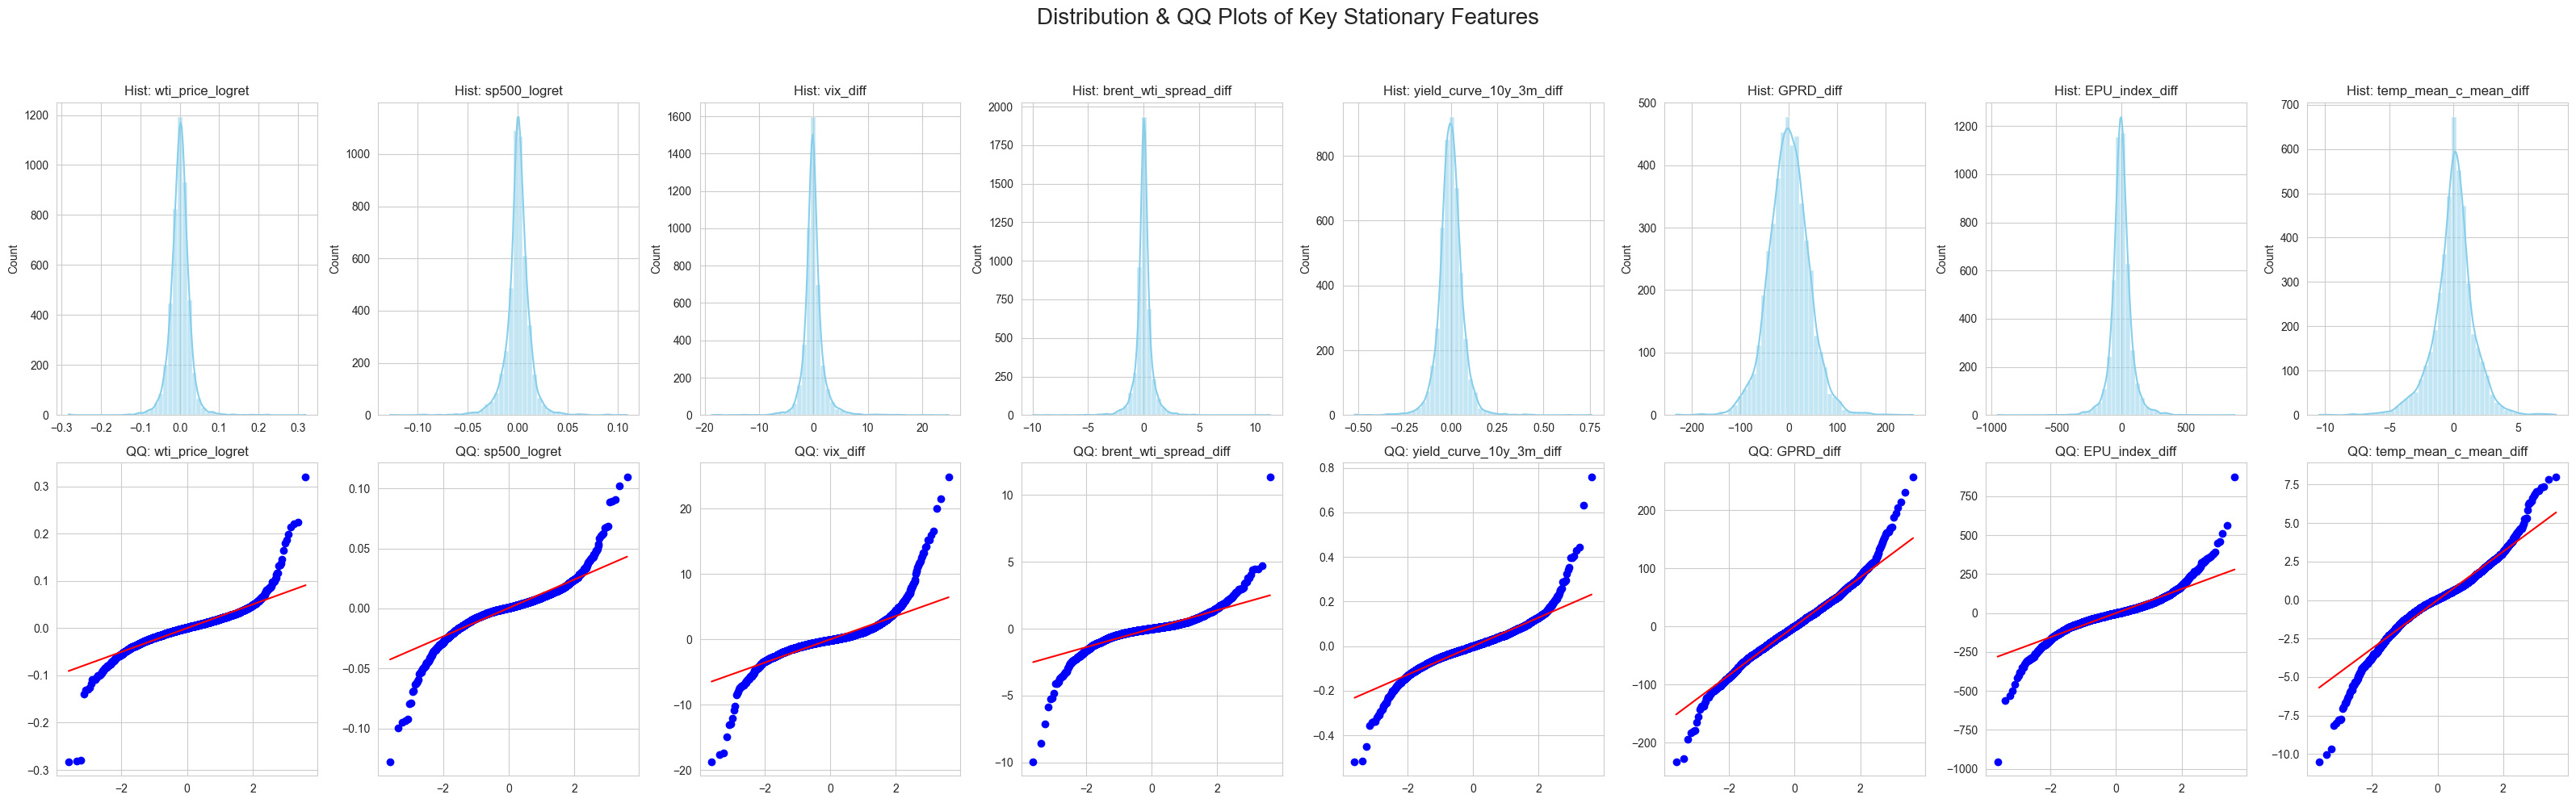

In [24]:
# --- Distribution analysis of selected stationary features ---
print("\n--- Distribution Analysis of Key Stationary Features ---")
from scipy import stats

# Select a few representative stationary features for detailed distribution plots
features_for_dist = [
    'wti_price_logret', 'sp500_logret', 'vix_diff', 'brent_wti_spread_diff',
    'yield_curve_10y_3m_diff', 'GPRD_diff', 'EPU_index_diff', 'temp_mean_c_mean_diff'
]

num_features = len(features_for_dist)
fig = plt.figure(figsize=(num_features * 4, 10)) # Adjust figure size dynamically
gs = fig.add_gridspec(2, num_features) # 2 rows for hist/qq, num_features columns

for i, col in enumerate(features_for_dist):
    if col in df_analysis.columns:
        # Histogram
        ax_hist = fig.add_subplot(gs[0, i])
        sns.histplot(df_analysis[col].dropna(), kde=True, bins=50, ax=ax_hist, color='skyblue')
        ax_hist.set_title(f'Hist: {col}', fontsize=12)
        ax_hist.set_xlabel('')

        # QQ Plot
        ax_qq = fig.add_subplot(gs[1, i])
        stats.probplot(df_analysis[col].dropna(), dist="norm", plot=ax_qq)
        ax_qq.set_title(f'QQ: {col}', fontsize=12)
        ax_qq.set_xlabel('')
        ax_qq.set_ylabel('')

plt.suptitle('Distribution & QQ Plots of Key Stationary Features', fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


--- Rolling Correlation Analysis ---


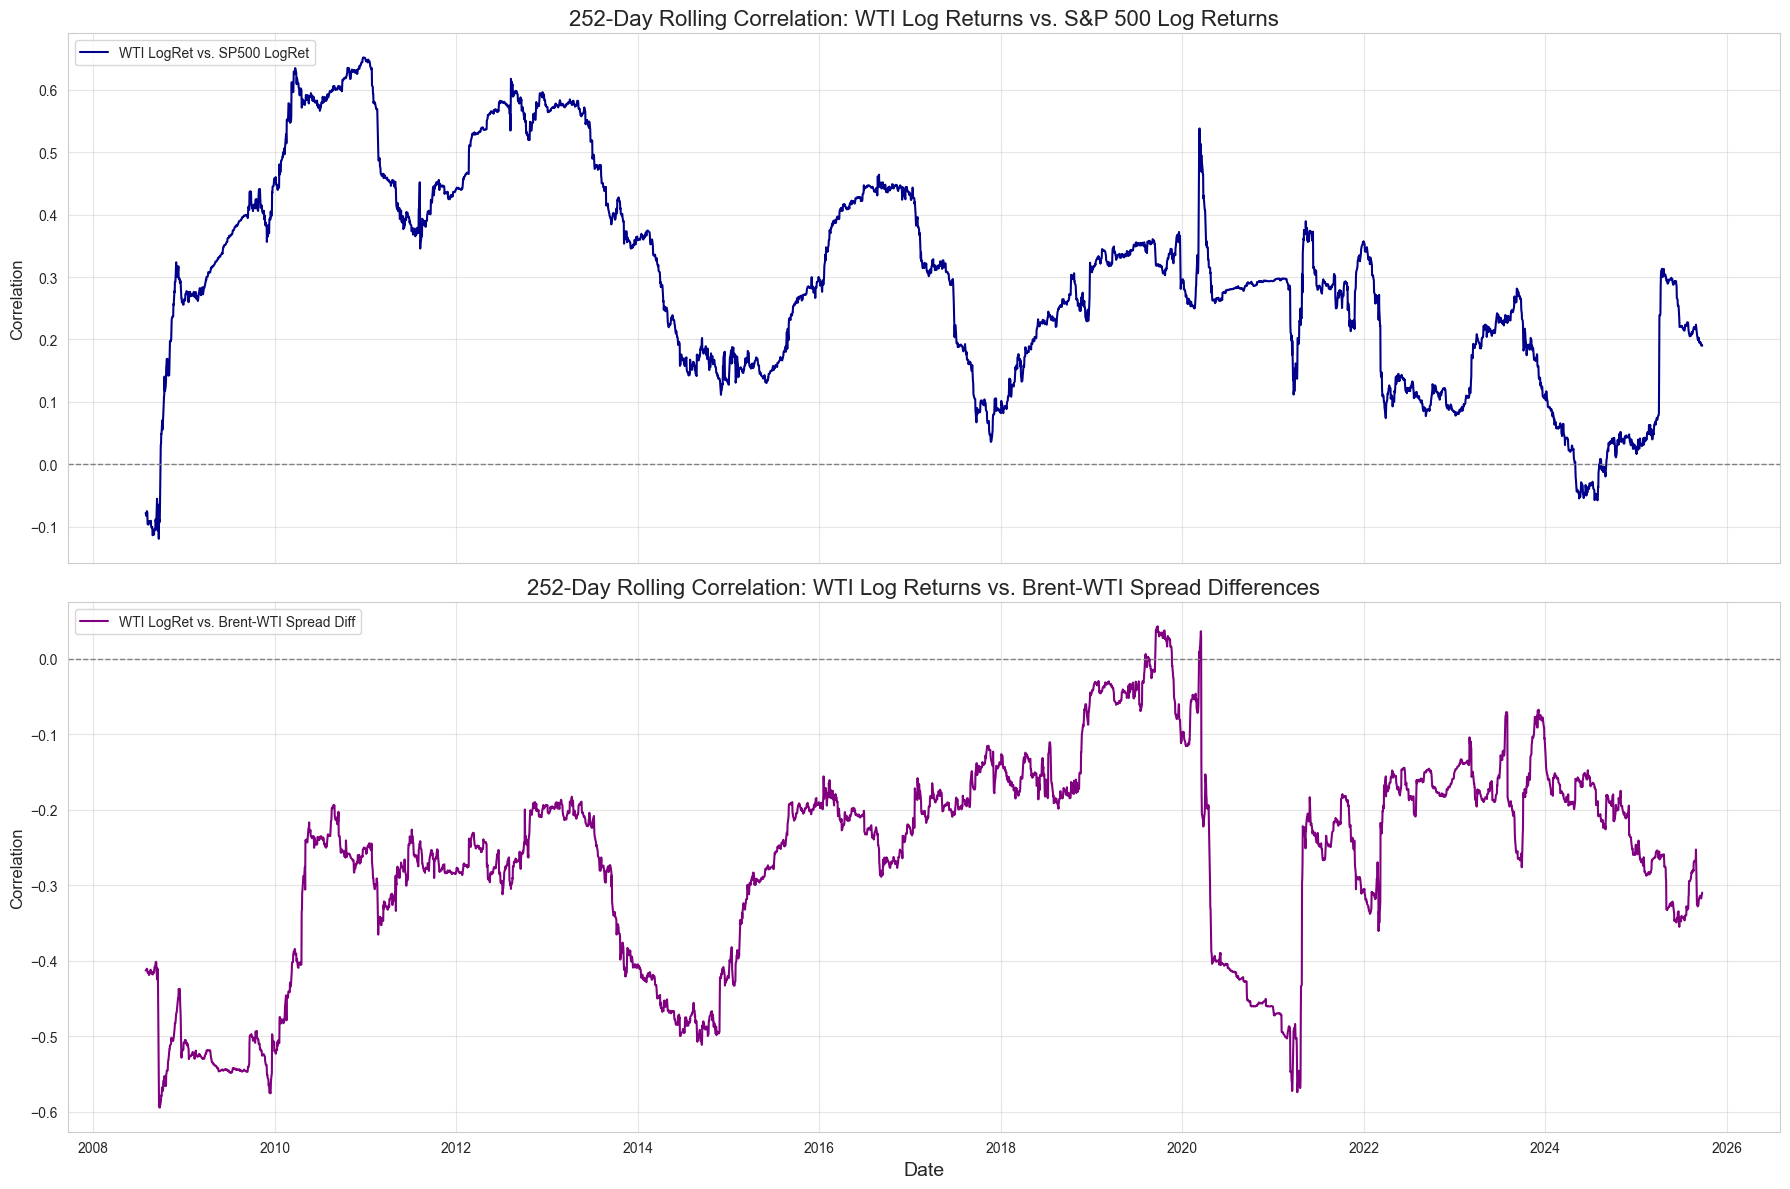

In [25]:
# --- Rolling correlation analysis ---
print("\n--- Rolling Correlation Analysis ---")
# Example: WTI Log Returns vs. S&P 500 Log Returns
rolling_corr_sp500 = df_analysis['wti_price_logret'].rolling(window=252).corr(df_analysis['sp500_logret'])

# Example: WTI Log Returns vs. Brent-WTI Spread (differenced)
rolling_corr_spread = df_analysis['wti_price_logret'].rolling(window=252).corr(df_analysis['brent_wti_spread_diff'])

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

axes[0].plot(rolling_corr_sp500.index, rolling_corr_sp500, color='darkblue', label='WTI LogRet vs. SP500 LogRet')
axes[0].axhline(0, color='grey', linestyle='--', lw=1)
axes[0].set_title('252-Day Rolling Correlation: WTI Log Returns vs. S&P 500 Log Returns', fontsize=16)
axes[0].set_ylabel('Correlation', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.5)

axes[1].plot(rolling_corr_spread.index, rolling_corr_spread, color='purple', label='WTI LogRet vs. Brent-WTI Spread Diff')
axes[1].axhline(0, color='grey', linestyle='--', lw=1)
axes[1].set_title('252-Day Rolling Correlation: WTI Log Returns vs. Brent-WTI Spread Differences', fontsize=16)
axes[1].set_ylabel('Correlation', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.5)

plt.xlabel('Date', fontsize=14)
plt.tight_layout()
plt.show()


--- Lead-Lag Analysis (Cross-Correlation) ---


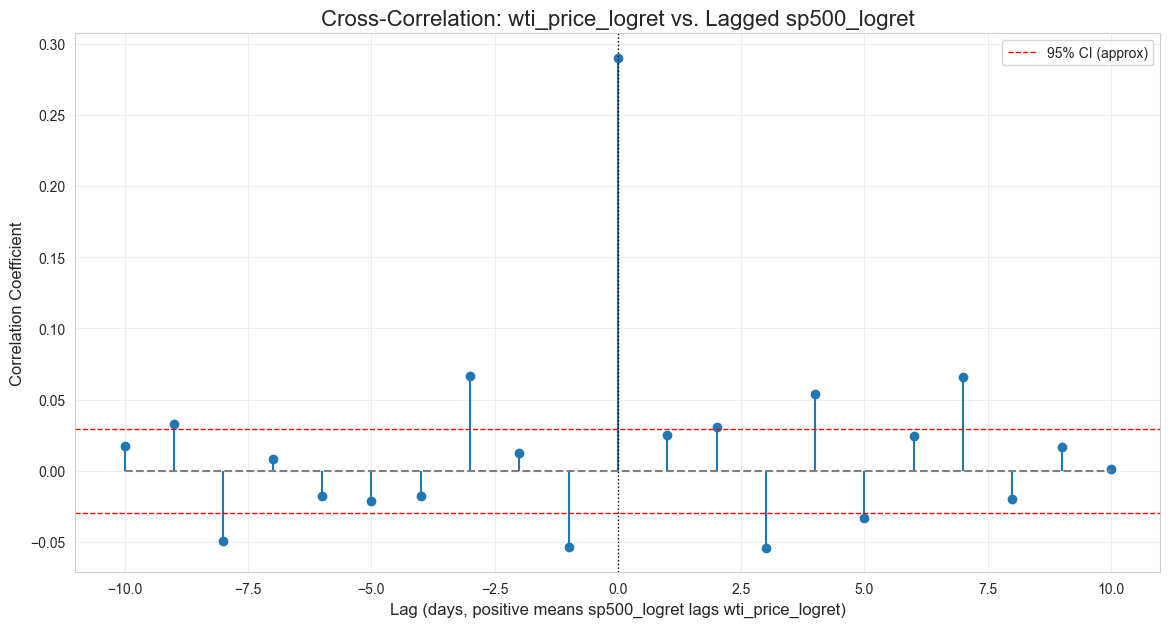

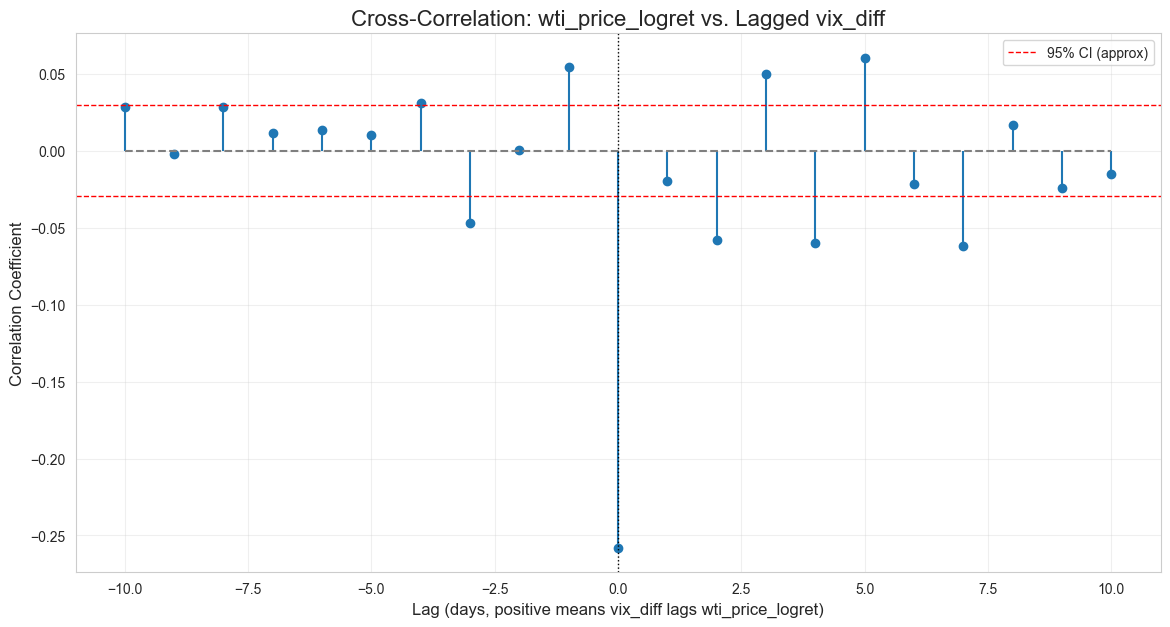

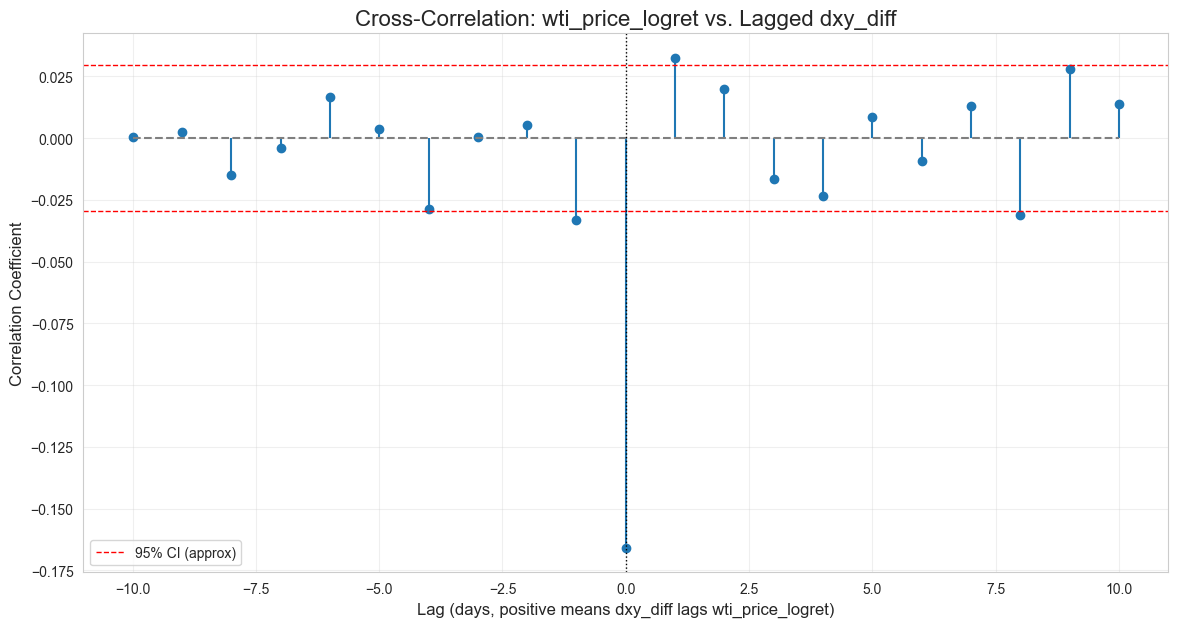

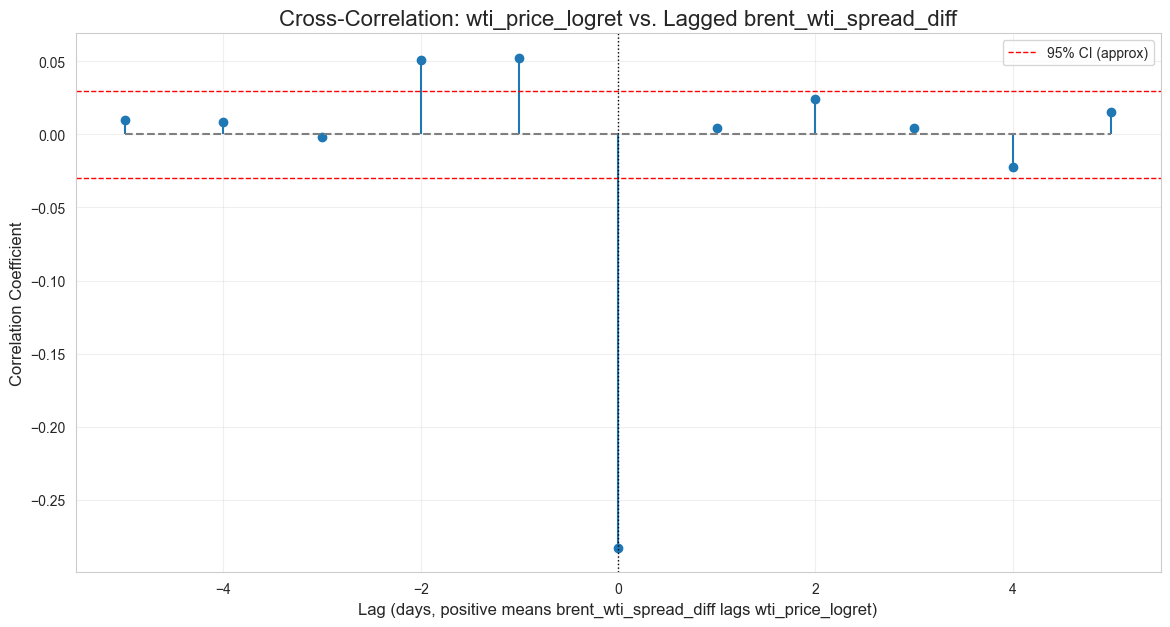

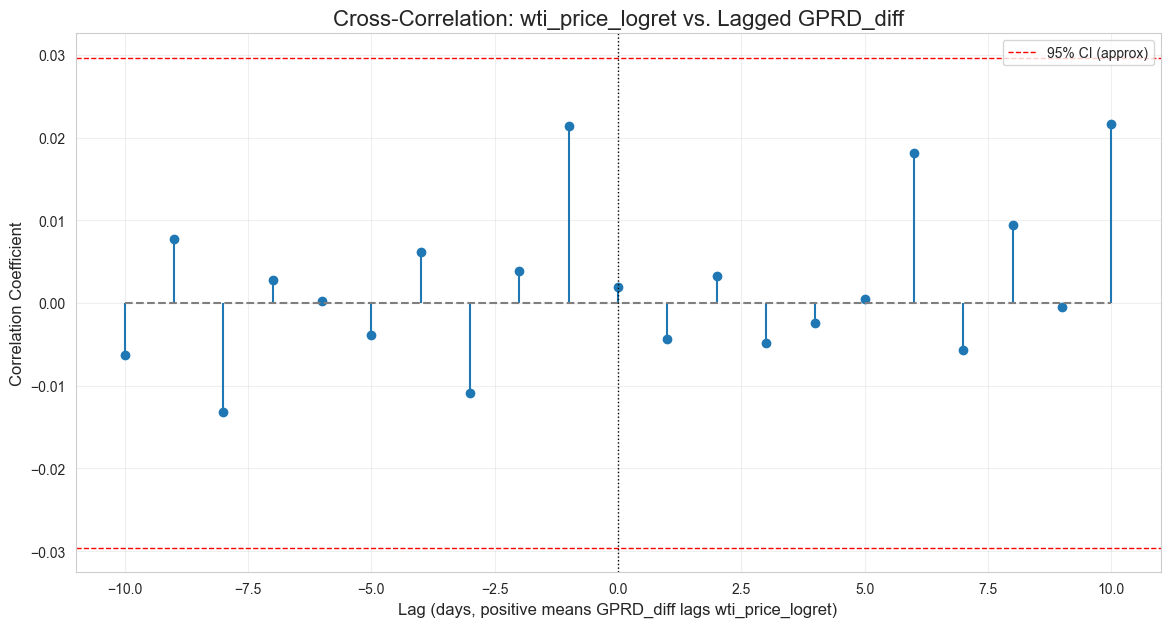

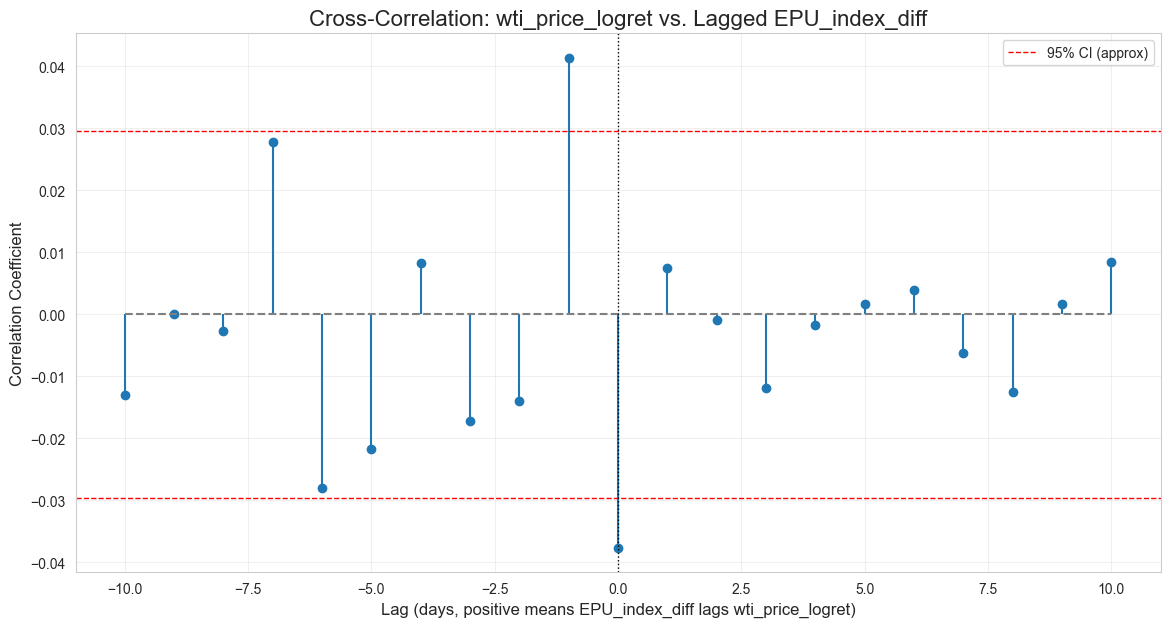

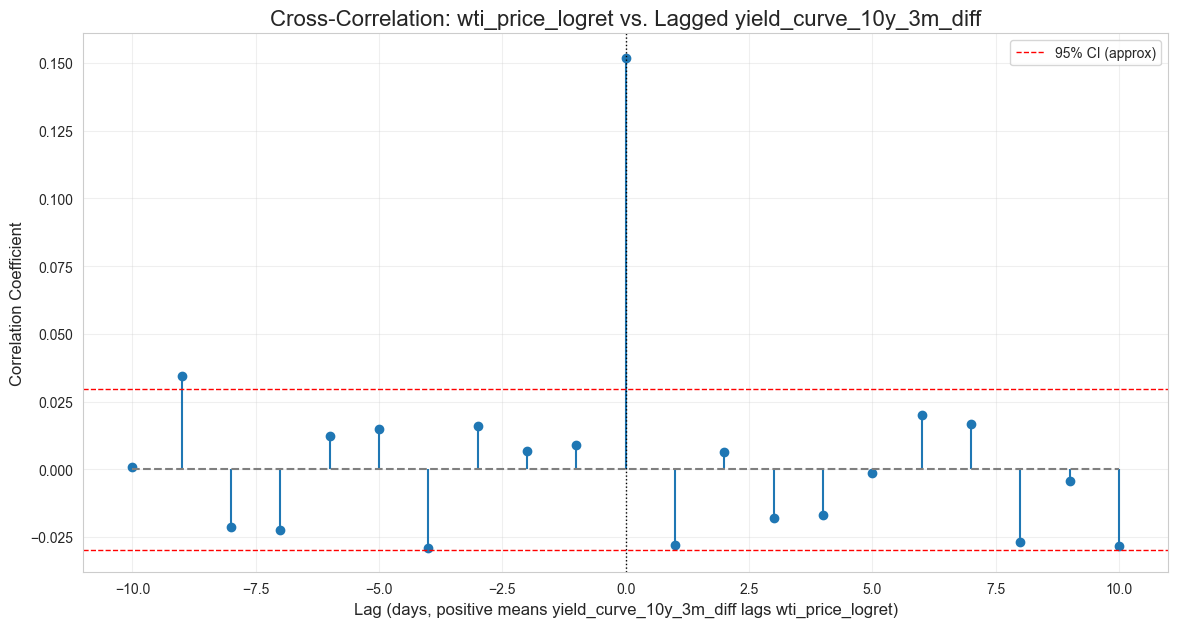

In [26]:
# --- Lead-lag (cross-correlation) analysis among key features ---
print("\n--- Lead-Lag Analysis (Cross-Correlation) ---")

# --- Key Cross-Correlations with your Target (`wti_price_logret`) ---
plot_cross_correlation(df_analysis, 'wti_price_logret', 'sp500_logret', max_lag=10)
plot_cross_correlation(df_analysis, 'wti_price_logret', 'vix_diff', max_lag=10)
plot_cross_correlation(df_analysis, 'wti_price_logret', 'dxy_diff', max_lag=10)
plot_cross_correlation(df_analysis, 'wti_price_logret', 'brent_wti_spread_diff', max_lag=5) # Shorter lag for spread
plot_cross_correlation(df_analysis, 'wti_price_logret', 'GPRD_diff', max_lag=10)
plot_cross_correlation(df_analysis, 'wti_price_logret', 'EPU_index_diff', max_lag=10)
plot_cross_correlation(df_analysis, 'wti_price_logret', 'yield_curve_10y_3m_diff', max_lag=10)


--- Feature-Target Scatter Plots ---


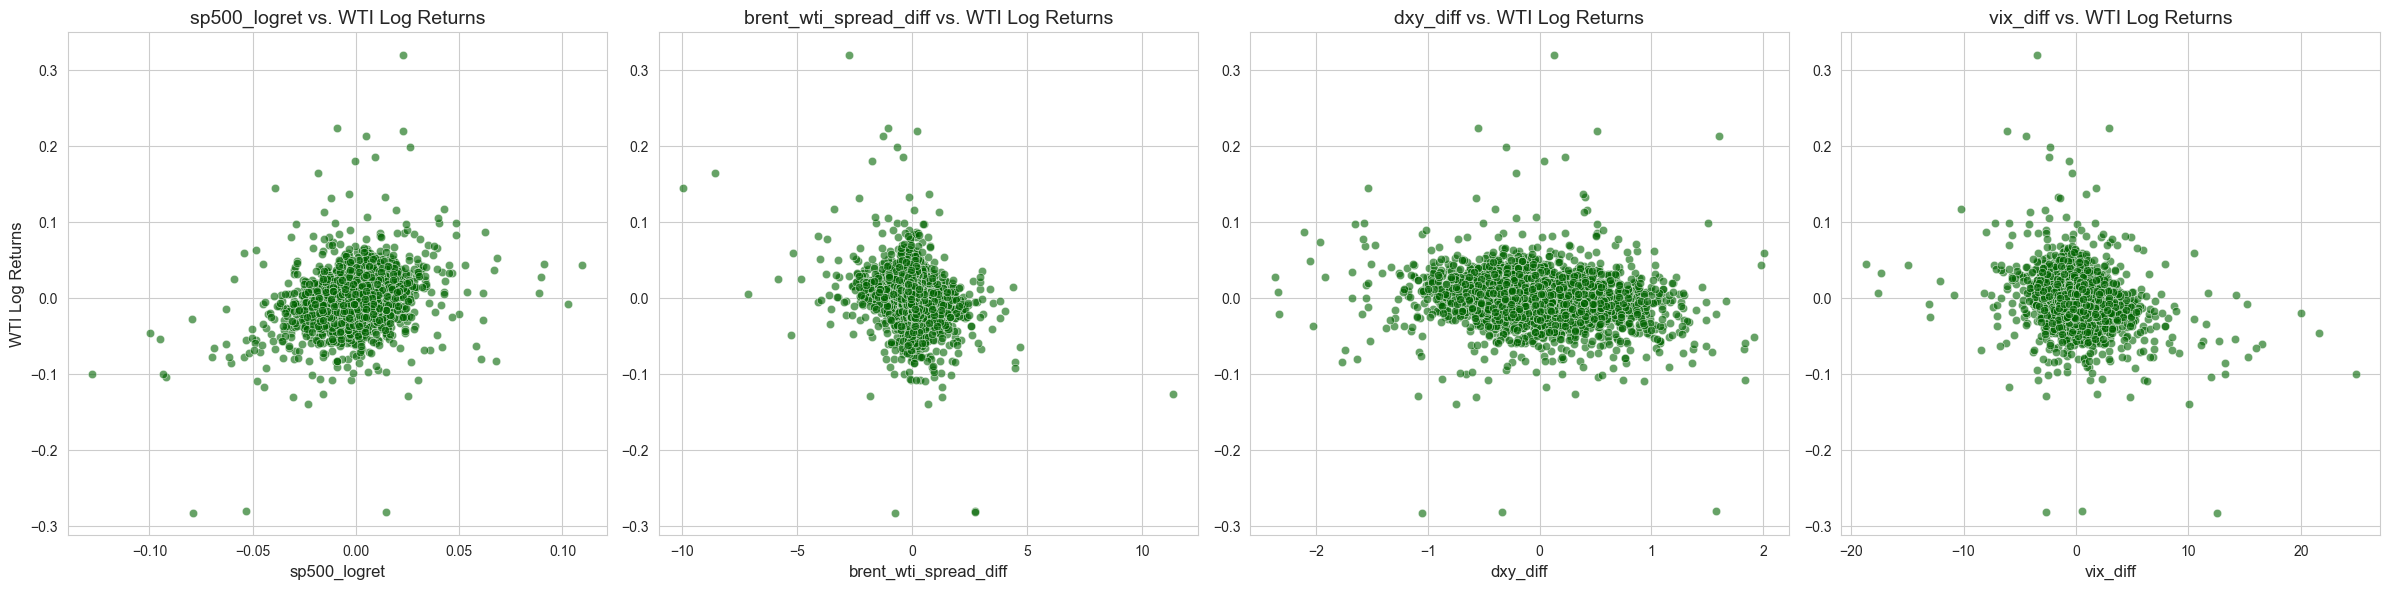

In [27]:
# --- Feature-target scatter plots ---
print("\n--- Feature-Target Scatter Plots ---")

# Choose a few top correlated features from your correlation matrix
# Ensure they are stationary features from df_analysis
features_for_scatter = [
    'sp500_logret', 'brent_wti_spread_diff', 'dxy_diff', 'vix_diff'
]

fig, axes = plt.subplots(1, len(features_for_scatter), figsize=(len(features_for_scatter) * 6, 6))
axes = axes.flatten()

for i, col in enumerate(features_for_scatter):
    if col in df_analysis.columns:
        sns.scatterplot(x=df_analysis[col], y=df_analysis['wti_price_logret'], ax=axes[i], alpha=0.6, color='darkgreen')
        axes[i].set_title(f'{col} vs. WTI Log Returns', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        if i == 0:
            axes[i].set_ylabel('WTI Log Returns', fontsize=12)
        else:
            axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


--- Seasonal Decomposition of Select Features ---


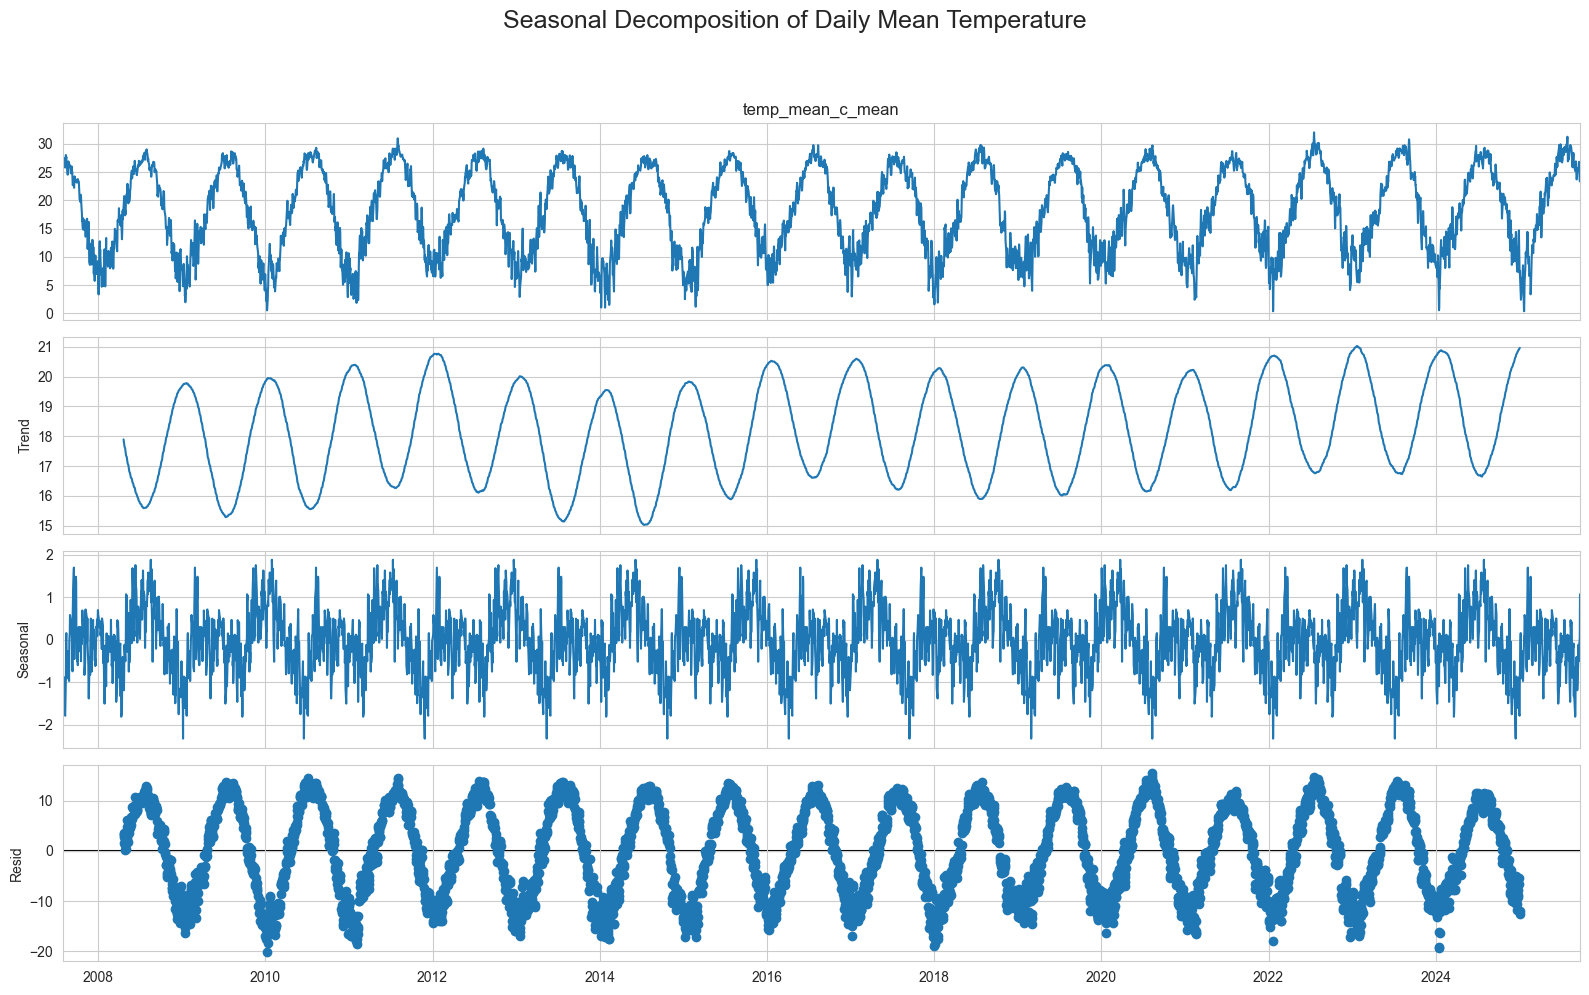

In [28]:
# --- Seasonal decomposition (if temp data exists) ---
print("\n--- Seasonal Decomposition of Select Features ---")
# Decompose a feature that *might* have seasonality (e.g., raw mean temperature)
# Note: Decomposition is typically for non-stationary series.
# Here, we will use the raw mean temperature (if available from 'df')

# You'll likely need to re-fetch/use the raw mean temperature data for this.
# Let's assume you have 'temp_mean_c_mean' available from the original `raw_data_final`
if 'temp_mean_c_mean' in raw_data_final.columns:
    # Resample to weekly or monthly if daily data is too noisy for clear seasonality
    # Or, apply to the raw daily data if it's clean enough
    temp_series = raw_data_final['temp_mean_c_mean'].dropna()

    if len(temp_series) > 2 * 365: # Need at least two full years for seasonal decomposition
        try:
            decomposition = seasonal_decompose(temp_series, model='additive', period=365) # Daily seasonality for weather

            fig = decomposition.plot()
            fig.set_size_inches(16, 10)
            fig.suptitle('Seasonal Decomposition of Daily Mean Temperature', fontsize=18, y=1.02)
            plt.tight_layout(rect=[0, 0.03, 1, 0.98])
            plt.show()
        except ValueError as e:
            print(f"Could not perform seasonal decomposition on temp_mean_c_mean: {e}")
            print("Often means data is too short or not regularly sampled for the period.")
    else:
        print("Not enough data for meaningful seasonal decomposition of temperature (requires > 2 years).")
else:
    print("Raw 'temp_mean_c_mean' not found for seasonal decomposition.")